In [347]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [348]:
def extract_params(directory_name, units):
    # Split the directory_name and construct the parameter dictionary directly
    params_dict = {}
    all_params = directory_name.split(',')
    for param in all_params:
        if '=' in param:
            name, val = param.split('=')
            
            # Handle values inside square brackets
            if '[' in val and ']' in val:
                val = val[val.index('[')+1:val.index(']')]
            
            # Extract numeric part of the value using regex
            numeric_val = re.search(r'-?\d+\.?\d*', val)
            if numeric_val:
                params_dict[name] = numeric_val.group()
                # Storing the unit separately in the units dictionary
                unit = re.search(r'[a-zA-Z]+$', val)
                if unit and name not in units:
                    units[name] = unit.group()
            else:
                params_dict[name] = val
        else:
            raise ValueError(f"Unexpected parameter format in {param}")
    
    return params_dict, units

def read_accuracy(file_path):
    # Open the file and read the value
    with open(file_path, 'r') as f:
        contents = f.read()

    # Extract the accuracy value using regex
    accuracy_match = re.search(r"Accuracy: (\d+(\.\d+)?)%", contents)
    return accuracy_match.group(1) if accuracy_match else None

def clean_file_name(file):
    unwanted_parts = ["model_accuracy_", ".txt", "_full_pixel"]
    for part in unwanted_parts:
        file = file.replace(part, "")
    return file

def build_dataframe(data, data_full_pixel):
    df = pd.DataFrame(data)
    df['accuracy'] = pd.to_numeric(df['accuracy'])
    if data_full_pixel:
        df_full_pixel = pd.DataFrame(data_full_pixel)
        df_full_pixel['accuracy(full pixel)'] = pd.to_numeric(df_full_pixel['accuracy(full pixel)'])
        merge_columns = df.columns[:-1].tolist()
        df = pd.merge(df, df_full_pixel, how='outer', on=merge_columns)
    return df

def extract_values(main_path):
    # Prepare an empty list to store data
    data = []
    data_full_pixel = []

    # Initialize dictionary to store units
    units = {}

    # Loop through each directory
    for root, dirs, _ in os.walk(main_path):
        # Check if the specific subdirectory is in the directory
        for directory in dirs:
            match = re.match(r"model_test_e(\d+)$", directory)
            if match:
                model_number = match.group(1)
                model_dir = os.path.join(root, directory)

                # Iterate over files in the model directory
                for _, _, files in os.walk(model_dir):
                    for file in files:
                        if re.search(r'model_accuracy_.*_regressor(_full_pixel)?\.txt$', file):
                            file_path = os.path.join(model_dir, file)

                            # Check if the specific file is in the subdirectory
                            if os.path.exists(file_path):
                                # Call the helper functions
                                directory_name = re.search(r"\((.*?)\)", os.path.basename(root)).group(1)
                                params_dict, units = extract_params(directory_name, units)
                                params_dict['used_regressor'] = clean_file_name(file)
                                params_dict['epoch'] = model_number
                                
                                # Check if it's a full pixel file
                                if "_full_pixel" in file:
                                    params_dict["accuracy(full pixel)"] = read_accuracy(file_path)
                                    data_full_pixel.append(params_dict)
                                else:
                                    params_dict['accuracy'] = read_accuracy(file_path)
                                    data.append(params_dict)

    # Call the helper function to build DataFrame
    df = build_dataframe(data, data_full_pixel)
    df = df.apply(pd.to_numeric, errors='ignore')
    print('data:',len(data))
    print('data_full_pixel:',len(data_full_pixel))
    print('Detected units:', units)

    return df

In [349]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def darken_cmap(cmap):
    cmap = cm.get_cmap(cmap)
    cmap_data = cmap(np.arange(cmap.N))
    
    # change the first RGB columns in each row (which form the colors) by taking
    # half their current value, effectively darkening the colormap
    cmap_data[:, :3] = cmap_data[:, :3] * 0.8
    
    return LinearSegmentedColormap.from_list('darkened_' + cmap.name, cmap_data, cmap.N)

In [350]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_avg_accuracy(df, x_param, line_param, filter_out=None, figsize=(10,6), points_notation=None, score_column='accuracy', agg_func='mean', plot_type='line'):
    # Apply the filter condition if provided
    if filter_out:
        for column, conditions in filter_out.items():
            if column not in df.columns:
                print(f"Column '{column}' not found in dataframe. Skipping this filter.")
                continue

            if not isinstance(conditions, list):
                conditions = [conditions]

            for condition in conditions:
                if condition not in df[column].unique():
                    print(f"Condition '{condition}' not found in column '{column}'. Skipping this condition.")
                    continue
                df = df[df[column] != condition]

    # Calculate aggregated score, standard deviation and count grouped by x_param and line_param
    grouped = df.groupby([x_param, line_param]).agg({score_column: [agg_func, 'std', 'size']}).reset_index()

    # Flatten the multi-level columns
    grouped.columns = ['_'.join(t).rstrip('_') for t in grouped.columns.values]

    # Rename columns for convenience
    grouped = grouped.rename(columns={f"{score_column}_{agg_func}": score_column, f"{score_column}_std": "std", f"{score_column}_size": "counts"})
    grouped.columns = [re.sub(r'_<lambda_0>', '', col) for col in grouped.columns]

    if plot_type == 'line':
        # Calculate the average count
        avg_count = grouped['counts'].mean()
        

        # Create a colormap and normalize object
        cmap = darken_cmap('RdYlGn_r') # '_r' indicates reverse order, so high values will be red and low values green
        norm = colors.Normalize(vmin=5, vmax=20) # values <=5 will be most green, >=20 will be most red

        # Create a new figure
        plt.figure(figsize=figsize)

        # Get unique line parameters
        unique_lines = grouped[line_param].unique()

        # Loop through each unique line parameter
        for line_val in unique_lines:
            # Filter the grouped DataFrame for the current line parameter
            line_data = grouped[grouped[line_param] == line_val]

            # Plot the data for this line parameter
            plt.plot(line_data[x_param], line_data[score_column], '.-',label=str(line_val))

            # Add data point count or standard deviation as text annotation next to each data point if points_notation is not None
            if points_notation:
                for i, point in line_data.iterrows():
                    if points_notation == 'std':
                        annotation = f"({point['std']:.1f})"
                        color = cmap(norm(point['std'])) if point['std'] <= 20 else cmap(1.0) # Maximum red color for std>20
                        plt.text(point[x_param], point[score_column], annotation, color=color, fontweight='bold')
                    elif points_notation == 'sp_count':
                        annotation = f"({point['counts']})"
                        color = 'black'
                        plt.text(point[x_param], point[score_column], annotation, color=color)
                    elif points_notation == 'val':
                        annotation = f"{point[score_column]:.2f}"
                        color = 'black'
                        plt.text(point[x_param], point[score_column], annotation, color=color)

        # Add a legend, grid, labels and a title
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True)
        plt.xlabel(f"{x_param} (Avg Count: {avg_count:.1f})")
        plt.ylabel(f'Average {agg_func} ')
        plt.title(f'Average {score_column} vs [{x_param}] for different [{line_param}]')
        plt.show()

    elif plot_type == 'heatmap':
        # Convert the DataFrame into a pivot table
        pivot = grouped.pivot(index=line_param, columns=x_param, values=score_column)

        # Create a new figure
        plt.figure(figsize=figsize)

        # Create the heatmap
        sns.heatmap(pivot, annot=True, cmap='RdYlGn', fmt=".2f")

        # Add a title
        plt.title(f'Average {score_column} vs [{x_param}] and [{line_param}]')
        plt.show()


In [351]:

def all_plots_pixel(data_df,figsize,filter_out={},points_notation=False,score_column='accuracy',agg_func='mean',plot_type='line'):
    for x_axis in data_df.columns[:-2]:
        for p_lines in data_df.columns[:-2]:
            if x_axis == p_lines:
                continue
            plot_avg_accuracy(data_df, x_axis, p_lines,filter_out=filter_out,figsize=figsize,points_notation=points_notation,score_column=score_column,agg_func=agg_func,plot_type=plot_type)

In [352]:
def extract_values(main_path):
    # Prepare an empty list to store data
    data = []
    data_full_pixel = []

    # Initialize dictionary to store units
    units = {}

    # Loop through each directory
    for root, dirs, _ in os.walk(main_path):
        # Check if the specific subdirectory is in the directory
        for directory in dirs:
            match = re.match(r"model_test_e(\d+)$", directory)
            if match:
                model_number = match.group(1)
                model_dir = os.path.join(root, directory)

                # Iterate over files in the model directory
                for _, _, files in os.walk(model_dir):
                    for file in files:
                        if re.search(r'model_accuracy_.*_regressor(_full_pixel)?\.txt$', file):
                            file_path = os.path.join(model_dir, file)

                            # Check if the specific file is in the subdirectory
                            if os.path.exists(file_path):
                                # Extracting parameters from directory name
                                directory_name = os.path.basename(root)
                                params_dict, units = extract_params(directory_name, units)
                                params_dict['used_regressor'] = clean_file_name(file)
                                params_dict['epoch'] = model_number

                                with open(file_path, 'r') as f:
                                    contents = f.read()

                                accuracy_match = re.search(r"Accuracy: (\d+(\.\d+)?)%", contents)
                                if accuracy_match:
                                    accuracy = accuracy_match.group(1)
                                    if "full_pixel" in file:
                                        params_dict['accuracy(full pixel)'] = accuracy
                                        data_full_pixel.append(params_dict)
                                    else:
                                        params_dict['accuracy'] = accuracy
                                        data.append(params_dict)

    # Call the helper function to build DataFrame
    df = build_dataframe(data, data_full_pixel)
    df = df.apply(pd.to_numeric, errors='ignore')
    print('data:',len(data))
    print('data_full_pixel:',len(data_full_pixel))
    print('Detected units:', units)

    return df

In [353]:
import numpy as np

def upper_ratio(ratio):
    return lambda x: sorted(x, reverse=True)[max(int(len(x) * ratio) - 1, 0)] if len(x) > 0 else None


def avg_range(a, b):
    def avg_inner_func(x):
        sorted_x = sorted(x, reverse=True)
        start_idx = max(int(len(x) * a) - 1, 0)
        end_idx = max(int(len(x) * b) - 1, 0) + 1  # +1 to make the range inclusive
        
        subset = sorted_x[start_idx:end_idx]
        
        return sum(subset) / len(subset) if subset else None
    
    return avg_inner_func

def std_range(a, b):
    def std_inner_func(x):
        sorted_x = sorted(x, reverse=True)
        start_idx = max(int(len(x) * a) - 1, 0)
        end_idx = max(int(len(x) * b) - 1, 0) + 1  # +1 to make the range inclusive
        
        subset = sorted_x[start_idx:end_idx]
        
        # If subset contains only one value, return 0
        if len(subset) == 1:
            return 0
        
        return np.std(subset, ddof=1) if subset else None  # ddof=1 for sample std deviation
    
    return std_inner_func




def plot_avg_accuracy(df, x_param, line_param, filter_out=None, figsize=(10,6), points_notation=None, score_column='accuracy', agg_func='mean', plot_type='line',a=0,b=1, custom_title=None, custom_xlabel=None, custom_ylabel=None, custom_legend=None):
   # Apply the filter condition if provided
    if filter_out:
        for column, conditions in filter_out.items():
            if column not in df.columns:
                print(f"Column '{column}' not found in dataframe. Skipping this filter.")
                continue

            if not isinstance(conditions, list):
                conditions = [conditions]

            for condition in conditions:
                if condition not in df[column].unique():
                    print(f"Condition '{condition}' not found in column '{column}'. Skipping this condition.")
                    continue
                df = df[df[column] != condition]

            
    if a == 0 and b == 1:
        # If deactivated, do the standard aggregation
        grouped = df.groupby([x_param, line_param]).agg({score_column: [agg_func, 'std', 'size']}).reset_index()
    else:
        # Use stats_range for aggregation
        ranging = avg_range(a, b)
        ranging_std = std_range(a, b)
        grouped = df.groupby([x_param, line_param]).agg({score_column: [ranging, ranging_std, 'size']}).reset_index()



    # Flatten the multi-level columns
    grouped.columns = ['_'.join(t).rstrip('_') for t in grouped.columns.values]

    # Rename columns for convenience
    grouped = grouped.rename(columns={f"{score_column}_{agg_func}": score_column, f"{score_column}_std": "std", f"{score_column}_size": "counts"})
    grouped.columns = [re.sub(r'_<lambda_0>', '', col) for col in grouped.columns]
    grouped.columns = [re.sub(r'_avg_inner_func', '', col) for col in grouped.columns]
    grouped.columns = [re.sub(f'^{re.escape(score_column)}_std_inner_func$', 'std', col) for col in grouped.columns]


    if plot_type == 'line':
        # Calculate the average count
        avg_count = grouped['counts'].mean()

        # Create a new figure
        plt.figure(figsize=figsize)

        # Get unique line parameters
        unique_lines = grouped[line_param].unique()

        # Loop through each unique line parameter
        for line_val in unique_lines:
            # Filter the grouped DataFrame for the current line parameter
            line_data = grouped[grouped[line_param] == line_val]

            # Check if points_notation is 'std' to decide whether to plot with error bars
            if points_notation == 'std':
                # Adjust the error values to ensure they lie within the range 0 to 100
                lower_error = np.minimum(line_data['std'], line_data[score_column])
                upper_error = np.minimum(line_data['std'], 100 - line_data[score_column])
                error = [lower_error.values, upper_error.values]

                plt.errorbar(line_data[x_param], line_data[score_column], yerr=error, fmt='-o', label=str(line_val), capsize=5,alpha=0.7)
            else:
                plt.plot(line_data[x_param], line_data[score_column], 'o-', label=str(line_val))

                # Add data point count or value as text annotation next to each data point if points_notation is not None
                for i, point in line_data.iterrows():
                    if points_notation == 'sp_count':
                        annotation = f"({point['counts']})"
                        color = 'black'
                        plt.text(point[x_param], point[score_column], annotation, color=color)
                    elif points_notation == 'val':
                        annotation = f"{point[score_column]:.2f}"
                        color = 'black'
                        plt.text(point[x_param], point[score_column], annotation, color=color)

        # Use custom labels and title if provided, else use default
        plt.xlabel(custom_xlabel if custom_xlabel else f"{x_param}")
        plt.ylabel(custom_ylabel if custom_ylabel else f'{agg_func} Accuracy')
        plt.title(custom_title if custom_title else f'Average {score_column} vs [{x_param}] for different [{line_param}]')
        plt.grid(True)
        
        # If custom_legend is provided, use it, else use the default legend
        if custom_legend:
            plt.legend(custom_legend)
        else:
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.show()

    elif plot_type == 'heatmap':
        # Convert the DataFrame into a pivot table
        pivot = grouped.pivot(index=line_param, columns=x_param, values=score_column)

        # Create a new figure
        plt.figure(figsize=figsize)

        # Create the heatmap
        heatmap=sns.heatmap(pivot, annot=True, cmap='RdYlGn', fmt=".2f")
        heatmap.collections[0].colorbar.set_label('Accuracy')

        # Add a title
        plt.title(custom_title if custom_title else f'Average {score_column} vs [{x_param}] and [{line_param}]')
        plt.show()


In [354]:
import pandas as pd

def expand_dataframe(df):
    """
    Expands the given DataFrame by duplicating its rows and modifying the 'accuracy' and 'window selection' columns.
    
    Parameters:
    - df (pd.DataFrame): The original DataFrame.
    
    Returns:
    - pd.DataFrame: The expanded DataFrame.
    """
    
    # Duplicate the DataFrame
    df_copy = df.copy()

    # Update the 'accuracy' column in the duplicated DataFrame
    df_copy['accuracy'] = df_copy['accuracy(full pixel)']

    # Set the 'window selection' column for the original and duplicated DataFrame
    df['window selection'] = 'with windowing'
    df_copy['window selection'] = 'without windowing'

    # Concatenate the two DataFrames
    df_final = pd.concat([df, df_copy], ignore_index=True)
    
    return df_final


In [383]:
print('Full size:',162*6*2)
path = '/home/ss2722/Desktop/Big_Big_Project/HPC_related/running_files/39.1_ABBA_NP4_method_combime(vp+no_sqre+pixel_w+loss_fn)_v6.51.1+seed/acc_results_with_info/'
case39_1_ = extract_values(path)

case39_1_.rename(columns={"v6.51_(vp": "vertual probes","seed":"random seed"}, inplace=True)
case39_1_['vertual probes'] = case39_1_['vertual probes'].replace({'no_vp': 'not using gradient probe', 'equal_vp': 'equal size gradient probe', 'larger_vp': 'larger gradient probe'})

case39_1_

Full size: 1944
data: 1944
data_full_pixel: 1944
Detected units: {}


vertual probes  no_sqre                  loss_fn  \
0     not using gradient probe  squared  balanced_reduction_loss   
1     not using gradient probe  squared  balanced_reduction_loss   
2     not using gradient probe  squared  balanced_reduction_loss   
3     not using gradient probe  squared  balanced_reduction_loss   
4     not using gradient probe  squared  balanced_reduction_loss   
...                        ...      ...                      ...   
1939  not using gradient probe  squared                  default   
1940  not using gradient probe  squared                  default   
1941  not using gradient probe  squared                  default   
1942  not using gradient probe  squared                  default   
1943  not using gradient probe  squared                  default   

      pixel_w_step  random seed       used_regressor  epoch  accuracy  \
0              0.0            1  max_value_regressor     49    100.00   
1              0.0            1   logistic_regressor     49    100.00   
2              0.0            1  max_value_regressor      0     72.92   
3              0.0            1   logistic_regressor      0    100.00   
4              0.0            1  max_value_regressor     42     75.00   
...            ...          ...                  ...    ...       ...   
1939           0.0           24   logistic_regressor     30    100.00   
1940           0.0           24  max_value_regressor     36    100.00   
1941           0.0           24   logistic_regressor     36    100.00   
1942           0.0           24  max_value_regressor     24    100.00   
1943           0.0           24   logistic_regressor     24    100.00   

      accuracy(full pixel)  
0                     75.0  
1                    100.0  
2                     25.0  
3                    100.0  
4                     75.0  
...                    ...  
1939                 100.0  
1940                  75.0  
1941                 100.0  
1942                 100.0  
1943                 100.0  

[1944 rows x 9 columns]

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.


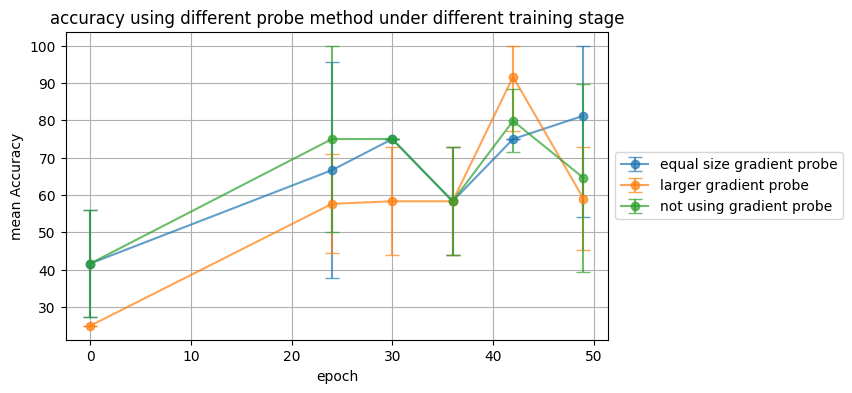

In [384]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_1_[(case39_1_['loss_fn']=='default')&(case39_1_['no_sqre']=='squared')&(case39_1_['pixel_w_step']==0)]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'vertual probes',filt_out,(7,4),'std','accuracy(full pixel)',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='accuracy using different probe method under different training stage', custom_xlabel=None, custom_ylabel=None)

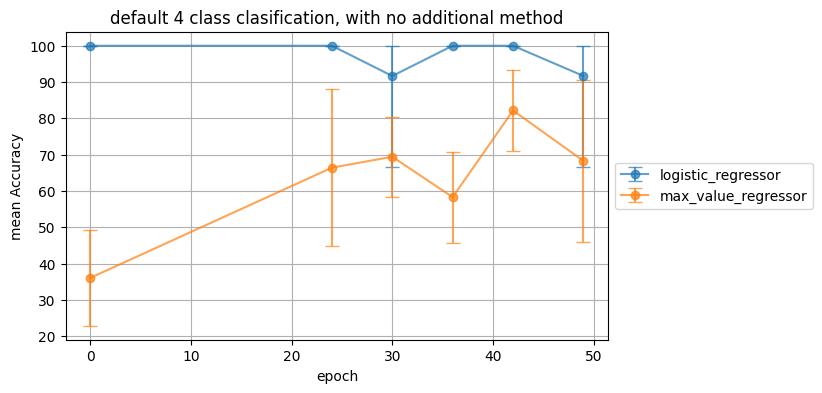

In [385]:
filt_out={}#{'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_1_[(case39_1_['loss_fn']=='default')&(case39_1_['no_sqre']=='squared')&(case39_1_['pixel_w_step']==0)]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'used_regressor',filt_out,(7,4),'std','accuracy(full pixel)',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='default 4 class clasification, with no additional method', custom_xlabel=None, custom_ylabel=None)

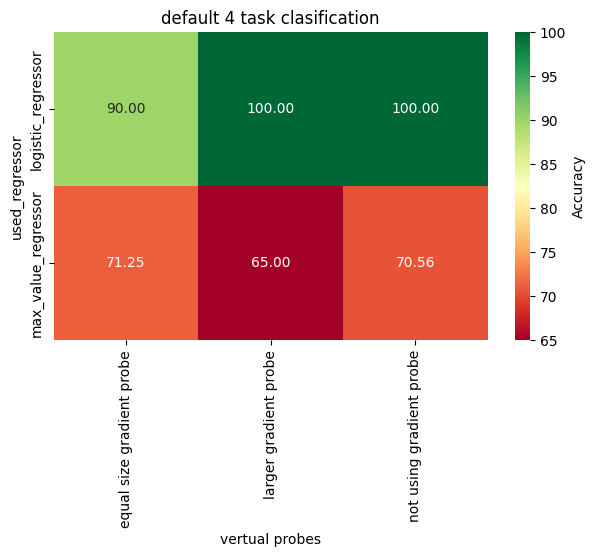

In [386]:
filt_out={}#{'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'heatmap'
data=case39_1_[(case39_1_['loss_fn']=='default')&(case39_1_['no_sqre']=='squared')&(case39_1_['pixel_w_step']==0)&(case39_1_['epoch']!=0)]
#data=case39_1_
plot_avg_accuracy(data, 'vertual probes', 'used_regressor',filt_out,(7,4),'std','accuracy(full pixel)',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='default 4 task clasification', custom_xlabel=None, custom_ylabel=None)

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.


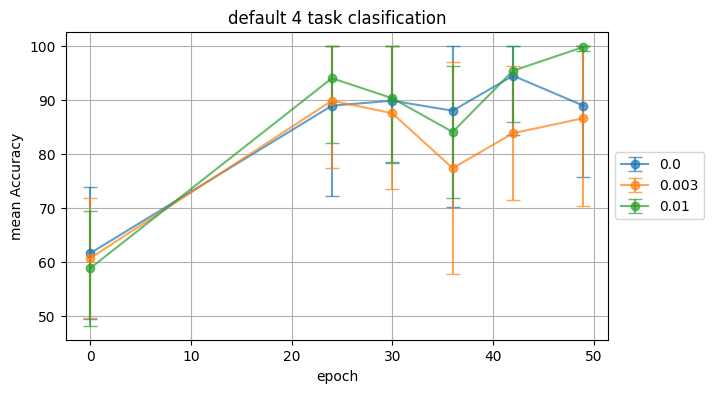

In [359]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_1_[(case39_1_['loss_fn']=='default')&(case39_1_['no_sqre']=='squared')]#&(case39_1_['epoch']!=0)]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'pixel_w_step',filt_out,(7,4),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='default 4 task clasification', custom_xlabel=None, custom_ylabel=None)

In [360]:
case39_1_loss_fn_=case39_1_[(case39_1_['vertual probes']=='no_vp')&(case39_1_['no_sqre']=='squared')&(case39_1_['pixel_w_step']==0)]

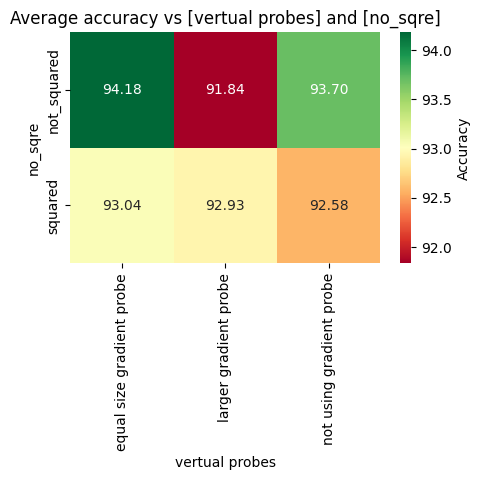

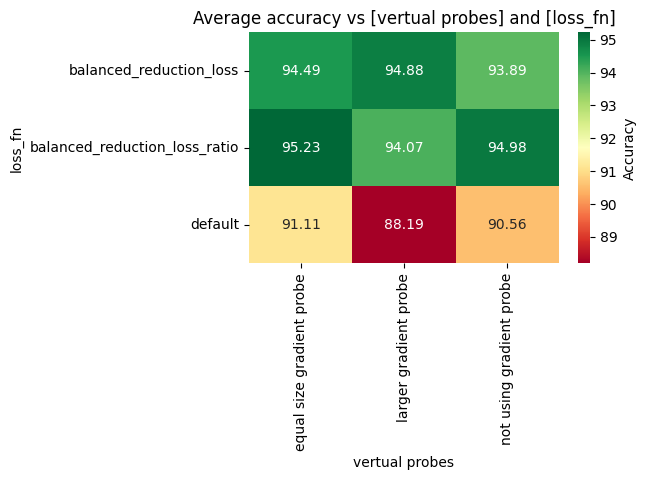

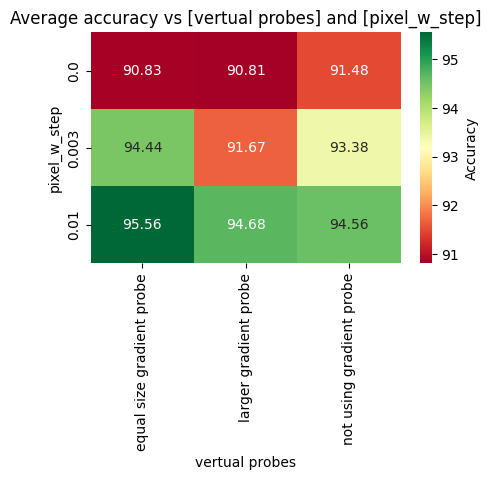

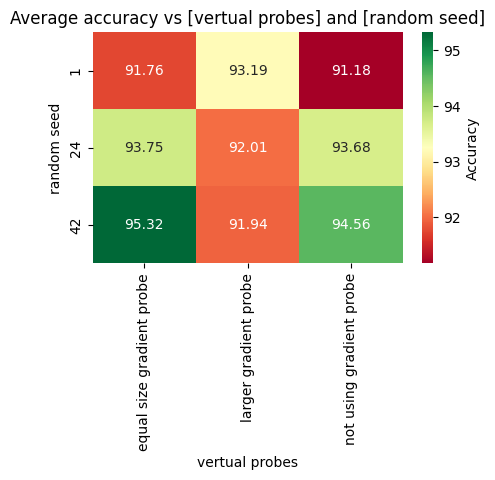

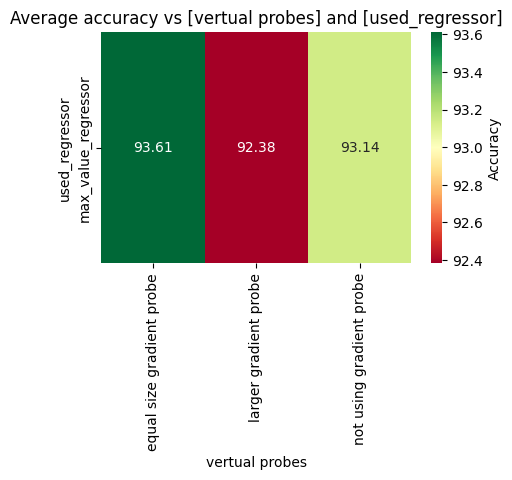

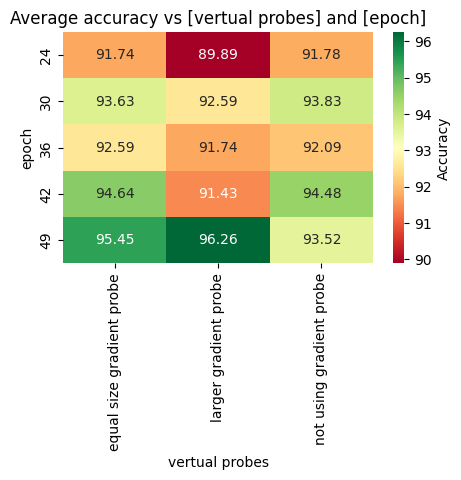

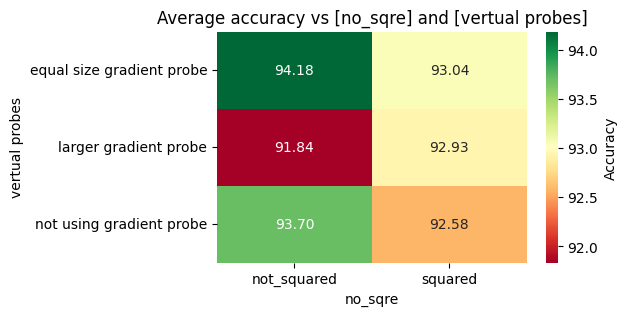

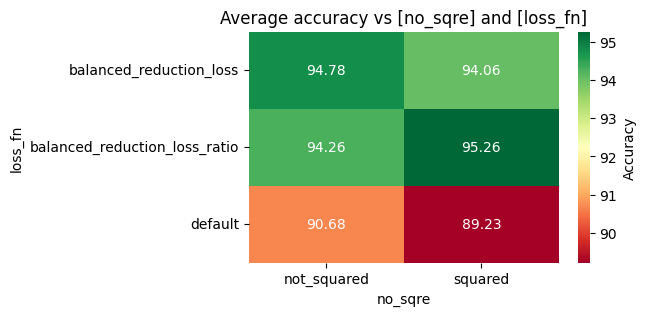

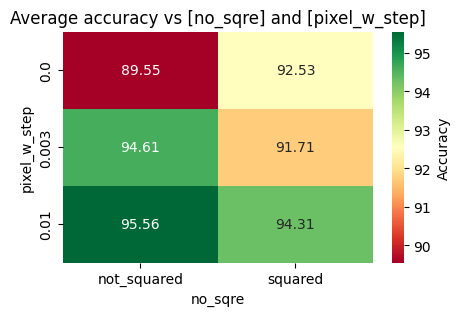

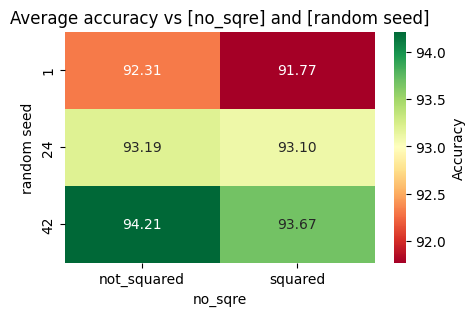

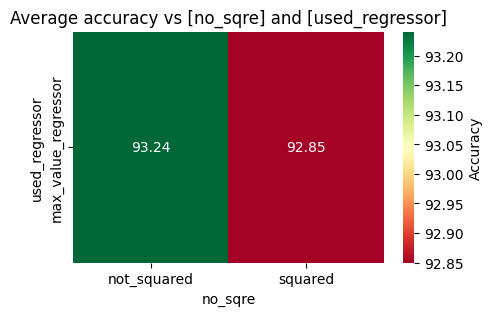

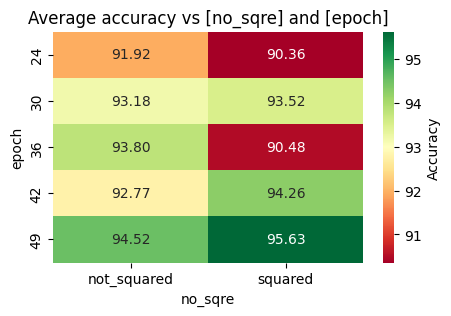

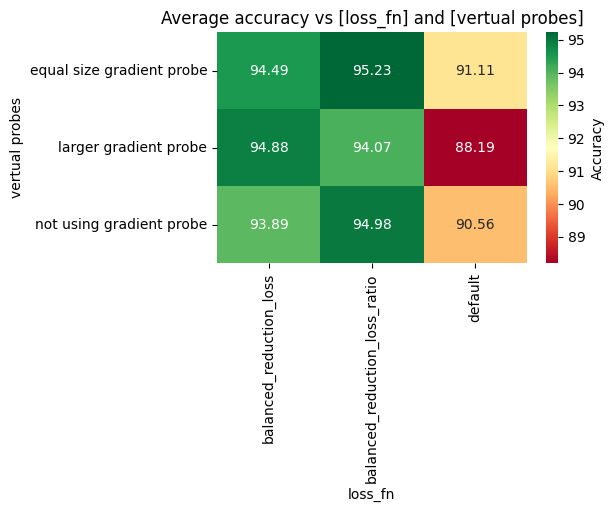

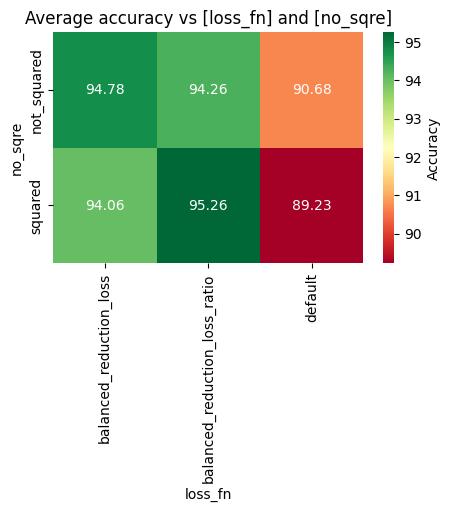

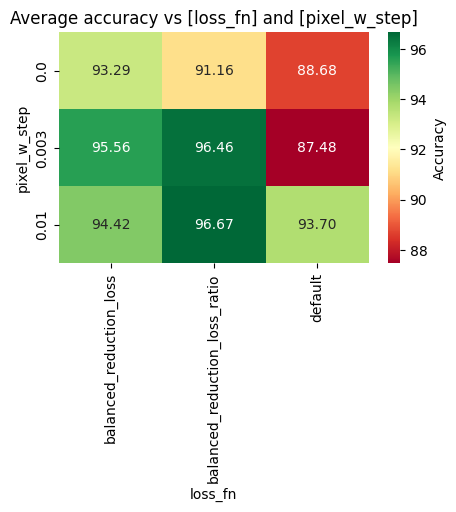

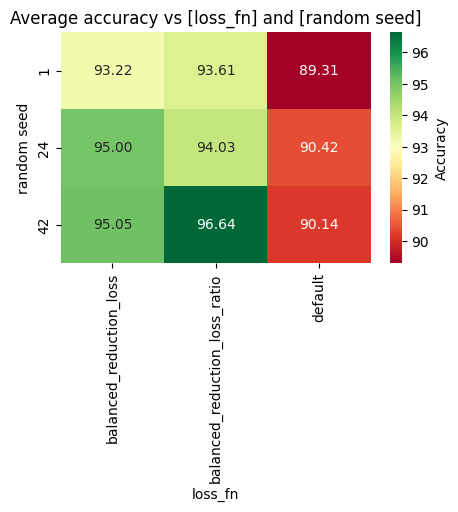

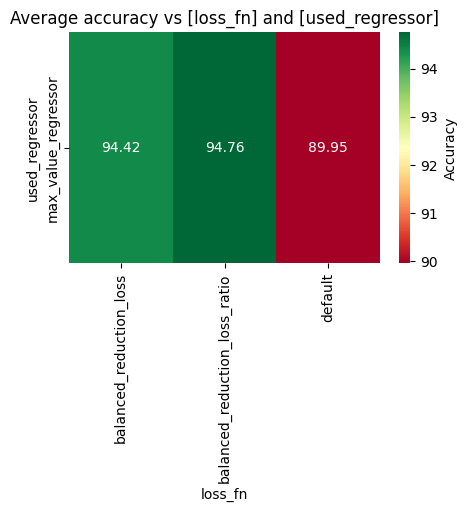

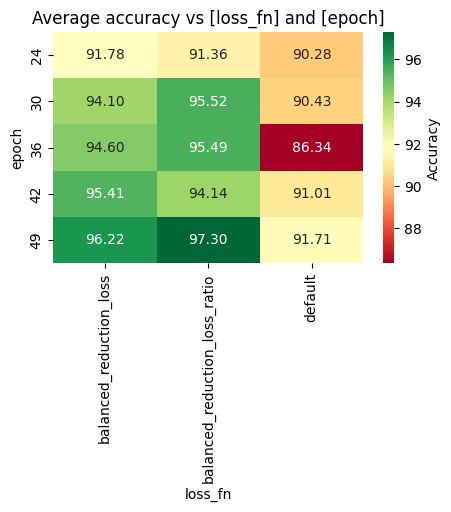

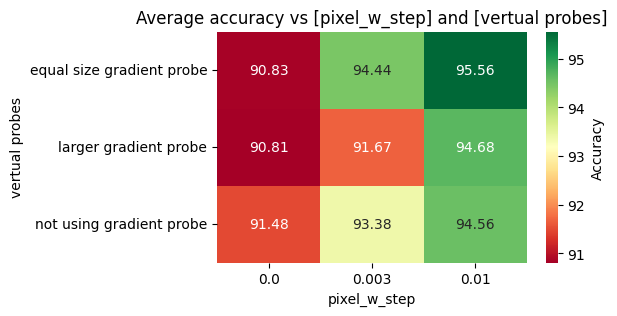

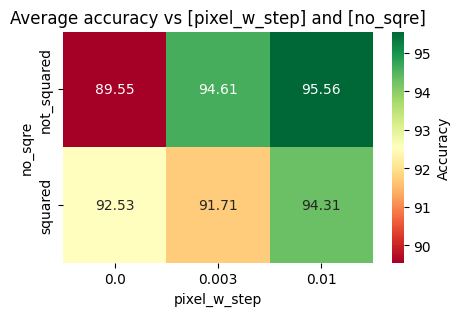

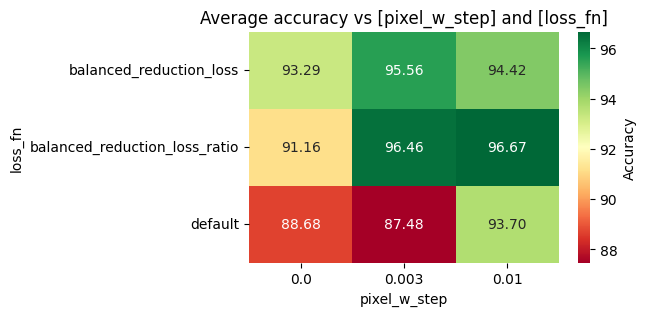

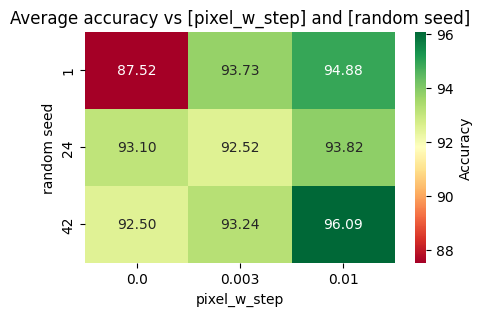

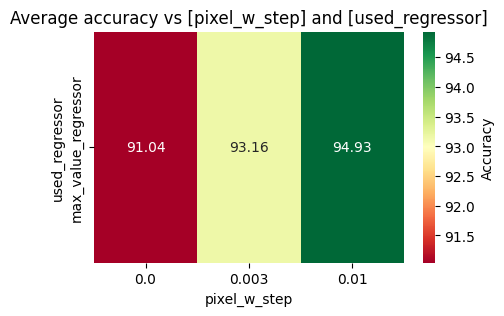

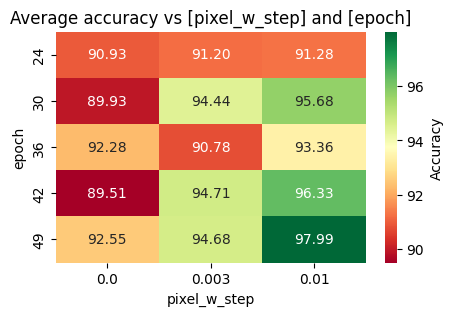

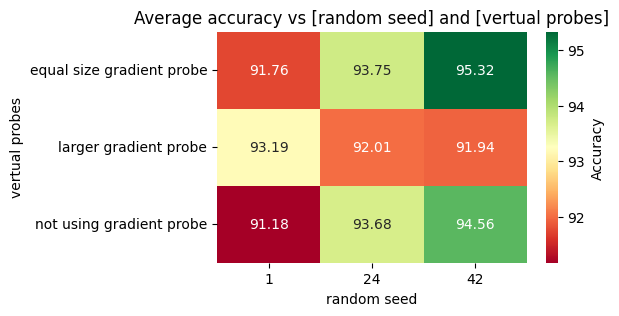

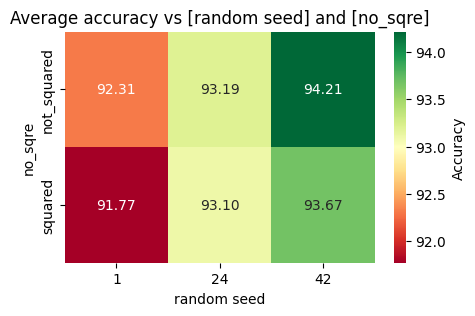

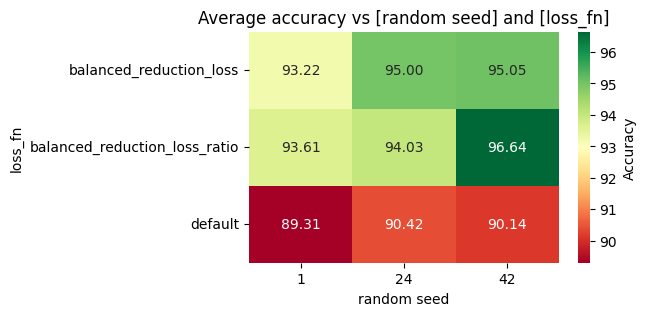

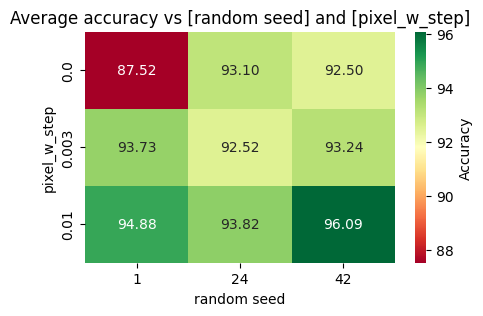

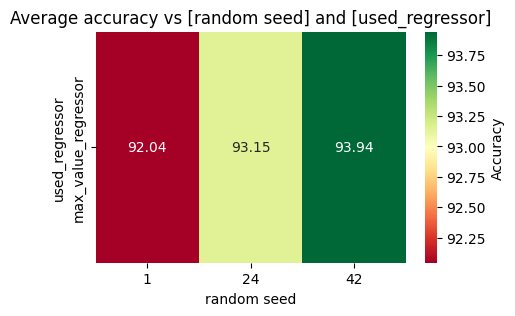

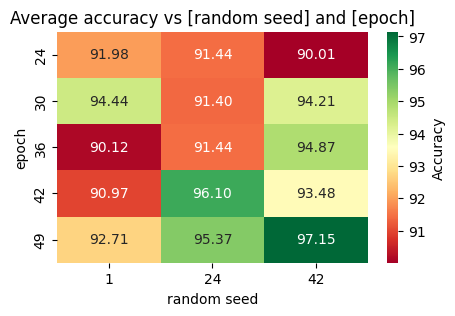

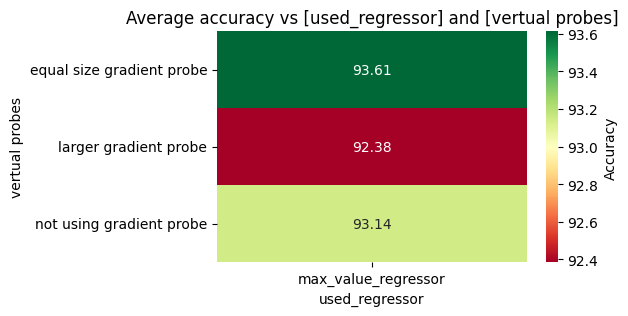

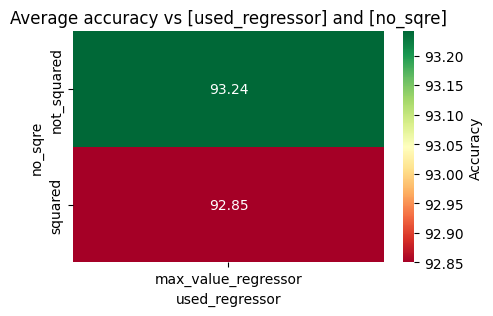

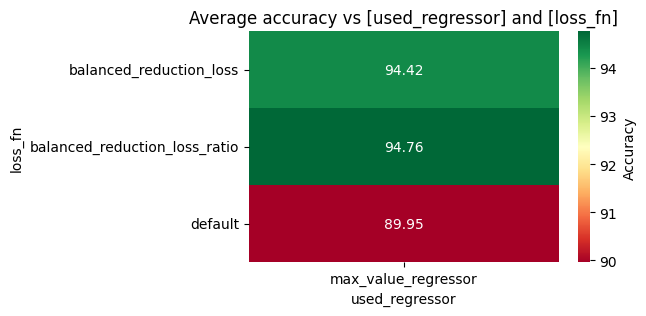

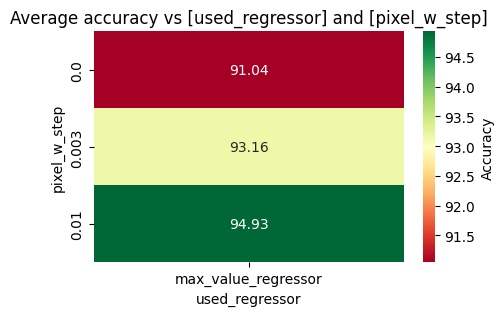

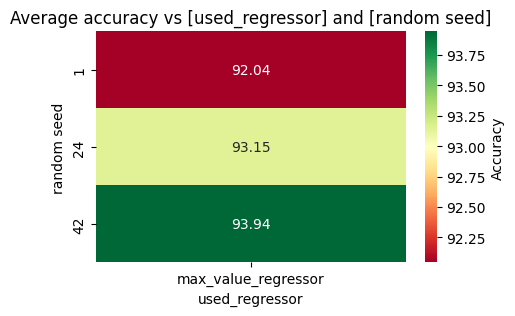

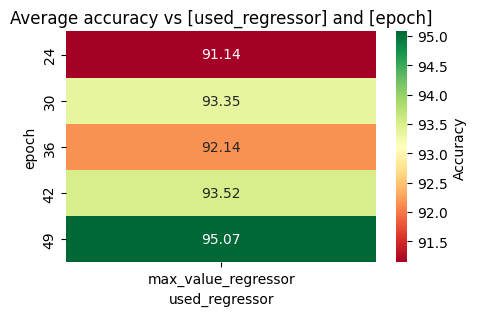

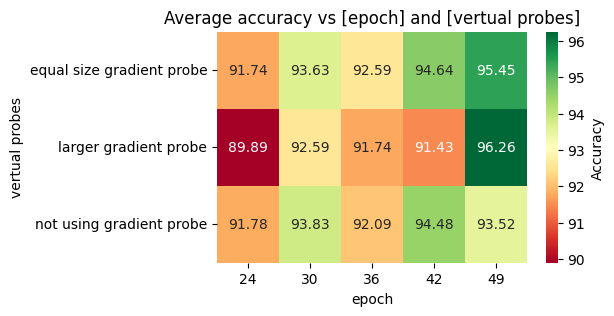

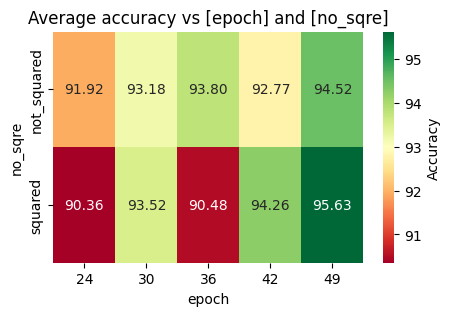

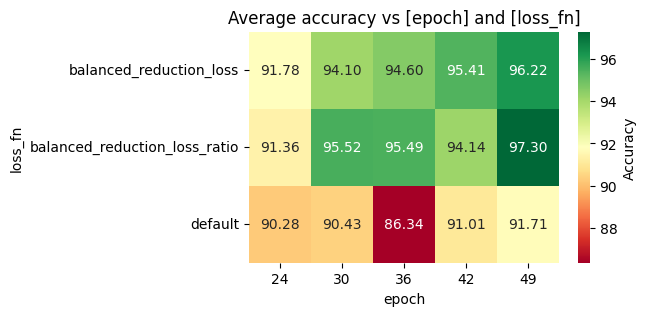

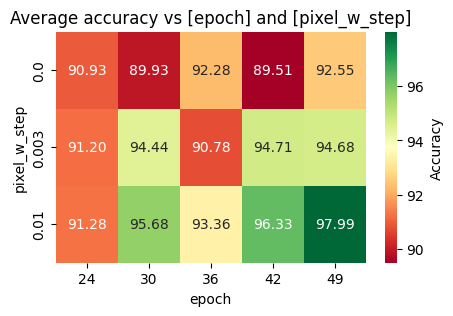

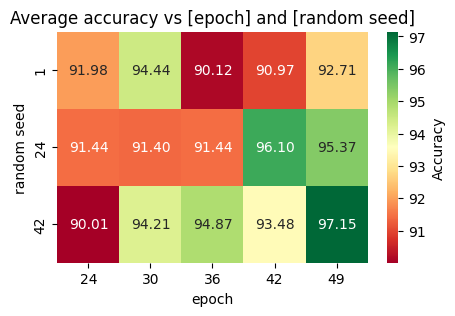

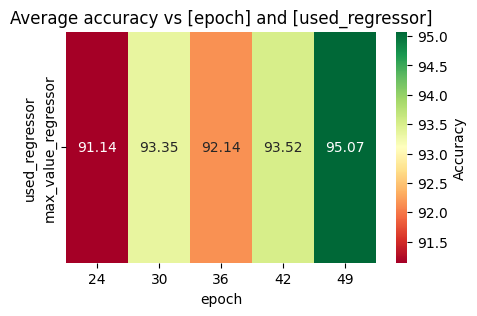

In [361]:
filt_out={'used_regressor': ['logistic_regressor']}#,'diff_regressor']}
all_plots_pixel(case39_1_[case39_1_['epoch']!=0],figsize=(5,3),points_notation=None,filter_out=filt_out,score_column='accuracy',plot_type='heatmap',agg_func='mean')

In [362]:
case39_1_window=expand_dataframe(case39_1_)
case39_1_window

vertual probes  no_sqre                  loss_fn  \
0     not using gradient probe  squared  balanced_reduction_loss   
1     not using gradient probe  squared  balanced_reduction_loss   
2     not using gradient probe  squared  balanced_reduction_loss   
3     not using gradient probe  squared  balanced_reduction_loss   
4     not using gradient probe  squared  balanced_reduction_loss   
...                        ...      ...                      ...   
3883  not using gradient probe  squared                  default   
3884  not using gradient probe  squared                  default   
3885  not using gradient probe  squared                  default   
3886  not using gradient probe  squared                  default   
3887  not using gradient probe  squared                  default   

      pixel_w_step  random seed       used_regressor  epoch  accuracy  \
0              0.0            1  max_value_regressor     49    100.00   
1              0.0            1   logistic_regressor     49    100.00   
2              0.0            1  max_value_regressor      0     72.92   
3              0.0            1   logistic_regressor      0    100.00   
4              0.0            1  max_value_regressor     42     75.00   
...            ...          ...                  ...    ...       ...   
3883           0.0           24   logistic_regressor     30    100.00   
3884           0.0           24  max_value_regressor     36     75.00   
3885           0.0           24   logistic_regressor     36    100.00   
3886           0.0           24  max_value_regressor     24    100.00   
3887           0.0           24   logistic_regressor     24    100.00   

      accuracy(full pixel)   window selection  
0                     75.0     with windowing  
1                    100.0     with windowing  
2                     25.0     with windowing  
3                    100.0     with windowing  
4                     75.0     with windowing  
...                    ...                ...  
3883                 100.0  without windowing  
3884                  75.0  without windowing  
3885                 100.0  without windowing  
3886                 100.0  without windowing  
3887                 100.0  without windowing  

[3888 rows x 10 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Condition 'logistic_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.


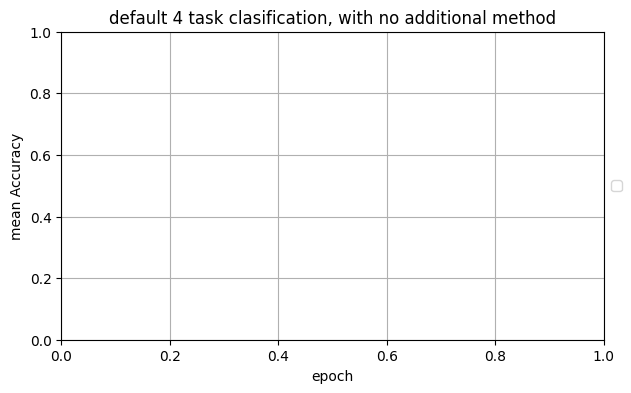

In [363]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_1_window[(case39_1_window['loss_fn']=='default')&(case39_1_window['no_sqre']=='squared')&(case39_1_window['vertual probes']=='no_vp')]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'window selection',filt_out,(7,4),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='default 4 task clasification, with no additional method', custom_xlabel=None, custom_ylabel=None)

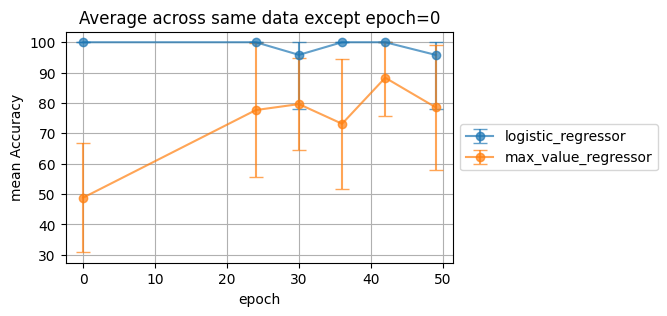

In [364]:
filt_out={}#{'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_1_window[(case39_1_window['loss_fn']=='default')&(case39_1_window['no_sqre']=='squared')&(case39_1_window['pixel_w_step']==0)]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'used_regressor',filt_out,(5,3),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='Average across same data except epoch=0', custom_xlabel=None, custom_ylabel=None)

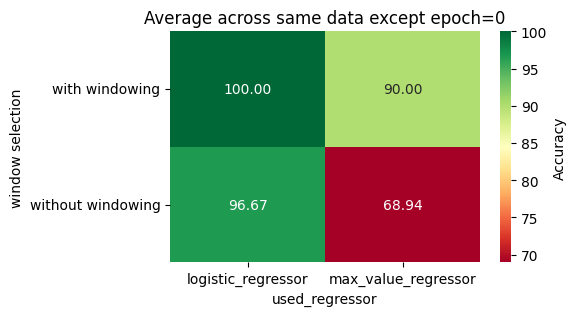

In [365]:
filt_out={}#{'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'heatmap'
data=case39_1_window[(case39_1_window['loss_fn']=='default')&(case39_1_window['no_sqre']=='squared')&(case39_1_window['pixel_w_step']==0)&(case39_1_window['epoch']!=0)]
#data=case39_1_
plot_avg_accuracy(data, 'used_regressor', 'window selection',filt_out,(5,3),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='Average across same data except epoch=0', custom_xlabel=None, custom_ylabel=None)

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.


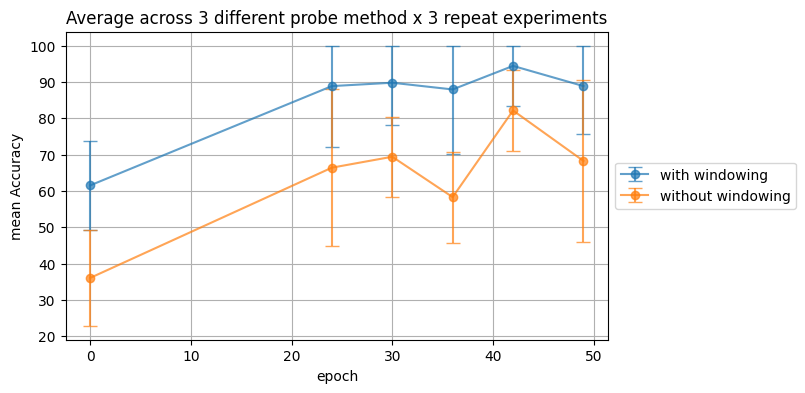

In [367]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_1_window[(case39_1_window['loss_fn']=='default')&(case39_1_window['no_sqre']=='squared')&(case39_1_window['pixel_w_step']==0)]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'window selection',filt_out,(7,4),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='Average across 3 different probe method x 3 repeat experiments', custom_xlabel=None, custom_ylabel=None)

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.


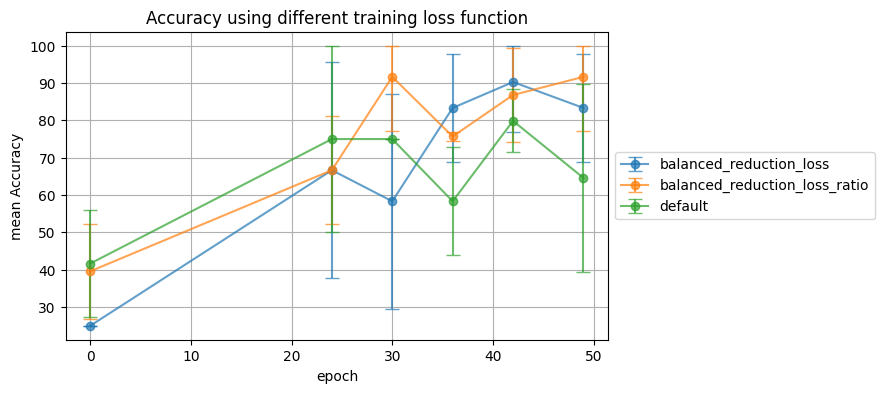

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_1_window[(case39_1_window['window selection']=='without windowing')&(case39_1_window['no_sqre']=='squared')&(case39_1_window['pixel_w_step']==0)&(case39_1_window['vertual probes']=='no_vp')]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'loss_fn',filt_out,(7,4),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='Accuracy using different training loss function', custom_xlabel=None, custom_ylabel=None)

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.


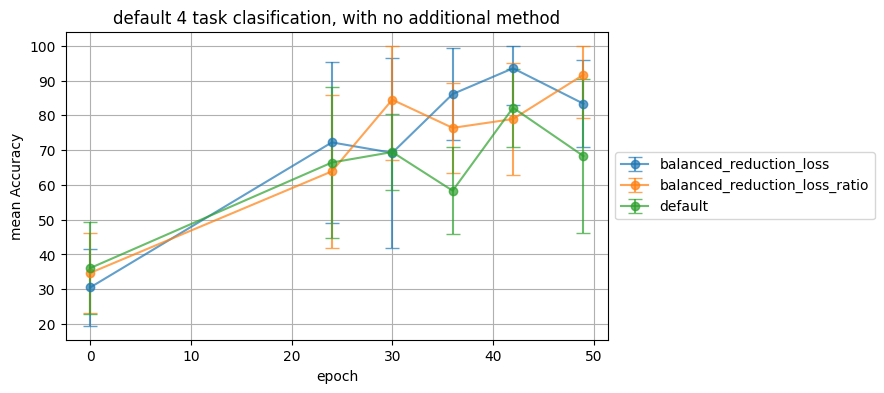

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_1_window[(case39_1_window['window selection']=='without windowing')&(case39_1_window['no_sqre']=='squared')&(case39_1_window['pixel_w_step']==0)]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'loss_fn',filt_out,(7,4),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='default 4 task clasification, with no additional method', custom_xlabel=None, custom_ylabel=None)

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.


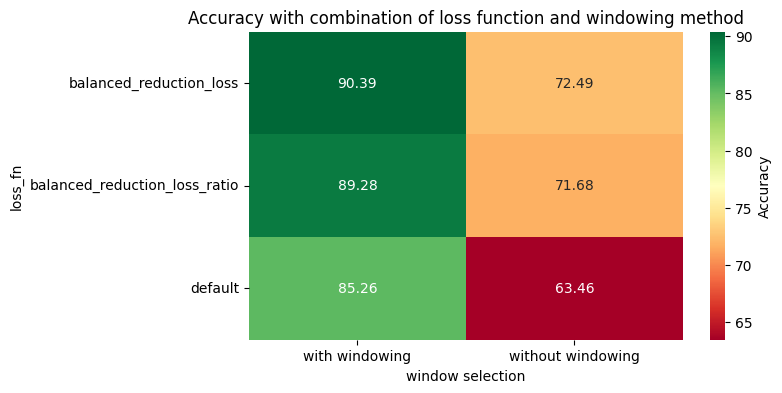

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'heatmap'
data=case39_1_window[(case39_1_window['no_sqre']=='squared')&(case39_1_window['pixel_w_step']==0)]
#data=case39_1_
plot_avg_accuracy(data, 'window selection', 'loss_fn',filt_out,(7,4),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='Accuracy with combination of loss function and windowing method', custom_xlabel=None, custom_ylabel='loss function used')

In [399]:
case39_1_window

vertual probes  no_sqre                  loss_fn  \
0     not using gradient probe  squared  balanced_reduction_loss   
1     not using gradient probe  squared  balanced_reduction_loss   
2     not using gradient probe  squared  balanced_reduction_loss   
3     not using gradient probe  squared  balanced_reduction_loss   
4     not using gradient probe  squared  balanced_reduction_loss   
...                        ...      ...                      ...   
3883  not using gradient probe  squared                  default   
3884  not using gradient probe  squared                  default   
3885  not using gradient probe  squared                  default   
3886  not using gradient probe  squared                  default   
3887  not using gradient probe  squared                  default   

      pixel_w_step  random seed       used_regressor  epoch  accuracy  \
0              0.0            1  max_value_regressor     49    100.00   
1              0.0            1   logistic_regressor     49    100.00   
2              0.0            1  max_value_regressor      0     72.92   
3              0.0            1   logistic_regressor      0    100.00   
4              0.0            1  max_value_regressor     42     75.00   
...            ...          ...                  ...    ...       ...   
3883           0.0           24   logistic_regressor     30    100.00   
3884           0.0           24  max_value_regressor     36     75.00   
3885           0.0           24   logistic_regressor     36    100.00   
3886           0.0           24  max_value_regressor     24    100.00   
3887           0.0           24   logistic_regressor     24    100.00   

      accuracy(full pixel)   window selection  
0                     75.0     with windowing  
1                    100.0     with windowing  
2                     25.0     with windowing  
3                    100.0     with windowing  
4                     75.0     with windowing  
...                    ...                ...  
3883                 100.0  without windowing  
3884                  75.0  without windowing  
3885                 100.0  without windowing  
3886                 100.0  without windowing  
3887                 100.0  without windowing  

[3888 rows x 10 columns]

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.


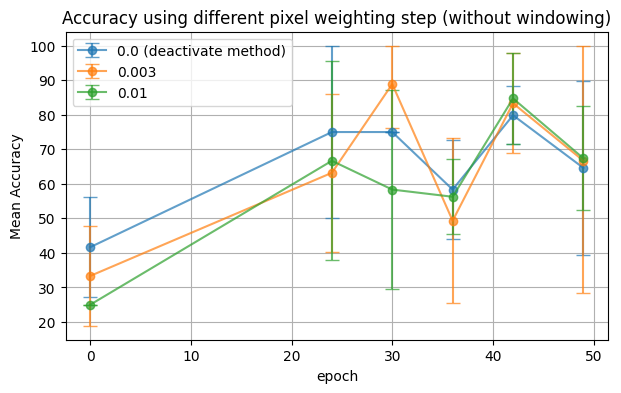

In [403]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_1_window[(case39_1_window['no_sqre']=='squared')&(case39_1_window['window selection']=='without windowing')&(case39_1_window['loss_fn']=='default')&(case39_1_window['vertual probes']=='not using gradient probe')]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'pixel_w_step',filt_out,(7,4),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='Accuracy using different pixel weighting step (without windowing)', custom_xlabel=None, custom_ylabel='Mean Accuracy',custom_legend=['0.0 (deactivate method)','0.003','0.01'])

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.


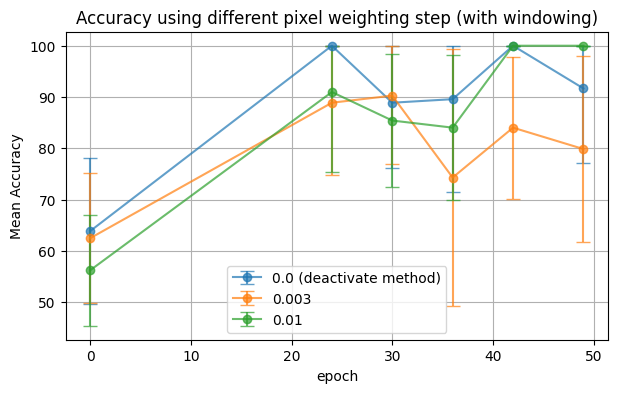

In [404]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_1_window[(case39_1_window['no_sqre']=='squared')&(case39_1_window['window selection']=='with windowing')&(case39_1_window['loss_fn']=='default')&(case39_1_window['vertual probes']=='not using gradient probe')]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'pixel_w_step',filt_out,(7,4),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='Accuracy using different pixel weighting step (with windowing)', custom_xlabel=None, custom_ylabel='Mean Accuracy',custom_legend=['0.0 (deactivate method)','0.003','0.01'])

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.


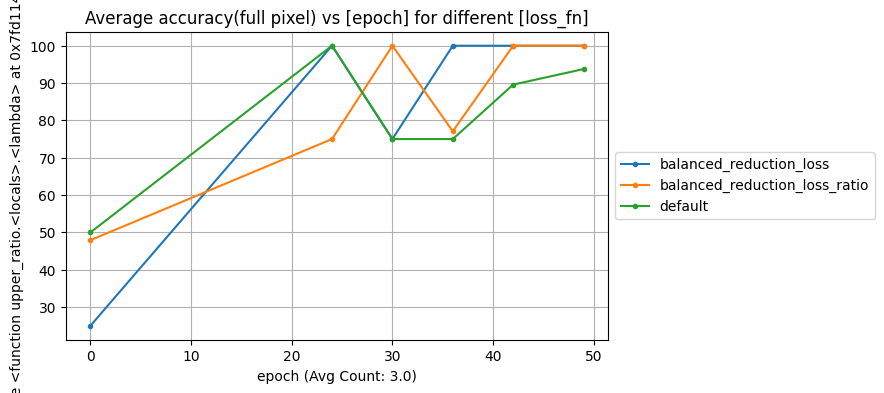

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor']}
plot_type = 'line'
plot_avg_accuracy(case39_1_loss_fn_, 'epoch', 'loss_fn',filt_out,figsize=(7,4),points_notation=None,score_column='accuracy(full pixel)',agg_func=upper_ratio(0.5),plot_type=plot_type)

In [ ]:
filt_out={'used_regressor': ['xlogistic_regressor','xdiff_regressor']}
plot_type = 'heatmap'
plot_avg_accuracy(case39_1_[case39_1_['pixel_w_step']==0.0], 'used_regressor', 'm_period',filt_out,figsize=(7,4),points_notation=None,score_column='accuracy',agg_func='mean',plot_type=plot_type)

Condition 'xlogistic_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xdiff_regressor' not found in column 'used_regressor'. Skipping this condition.


KeyError: 'm_period'

In [ ]:
print('Full size:',162*6*2)
path = '/home/ss2722/Desktop/Big_Big_Project/HPC_related/running_files/39.2_ABBA_NP4_harder_method_combime(vp+no_sqre+pixel_w+loss_fn)_v6.51.2+seed/acc_results_with_info/'
case39_2_ = extract_values(path)

case39_2_.rename(columns={"v6.51_(vp": "vertual probes","seed":"random seed"}, inplace=True)
case39_2_window=expand_dataframe(case39_2_)
case39_2_window

Full size: 1944
data: 1944
data_full_pixel: 1944
Detected units: {}


vertual probes  no_sqre                  loss_fn  pixel_w_step  \
0             no_vp  squared  balanced_reduction_loss           0.0   
1             no_vp  squared  balanced_reduction_loss           0.0   
2             no_vp  squared  balanced_reduction_loss           0.0   
3             no_vp  squared  balanced_reduction_loss           0.0   
4             no_vp  squared  balanced_reduction_loss           0.0   
...             ...      ...                      ...           ...   
3883          no_vp  squared                  default           0.0   
3884          no_vp  squared                  default           0.0   
3885          no_vp  squared                  default           0.0   
3886          no_vp  squared                  default           0.0   
3887          no_vp  squared                  default           0.0   

      random seed       used_regressor  epoch  accuracy  accuracy(full pixel)  \
0               1  max_value_regressor     49     100.0                 100.0   
1               1   logistic_regressor     49     100.0                 100.0   
2               1  max_value_regressor      0      75.0                  50.0   
3               1   logistic_regressor      0     100.0                 100.0   
4               1  max_value_regressor     42     100.0                 100.0   
...           ...                  ...    ...       ...                   ...   
3883           24   logistic_regressor     30     100.0                 100.0   
3884           24  max_value_regressor     36      50.0                  50.0   
3885           24   logistic_regressor     36     100.0                 100.0   
3886           24  max_value_regressor     24      87.5                  87.5   
3887           24   logistic_regressor     24     100.0                 100.0   

       window selection  
0        with windowing  
1        with windowing  
2        with windowing  
3        with windowing  
4        with windowing  
...                 ...  
3883  without windowing  
3884  without windowing  
3885  without windowing  
3886  without windowing  
3887  without windowing  

[3888 rows x 10 columns]

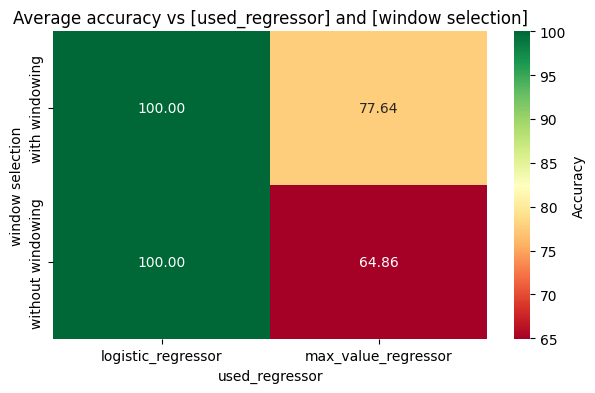

In [ ]:
filt_out={}#{'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'heatmap'
data=case39_2_window[(case39_2_window['loss_fn']=='default')&(case39_2_window['no_sqre']=='squared')&(case39_2_window['pixel_w_step']==0)&(case39_2_window['pixel_w_step']==0)&(case39_2_window['epoch']!=0)]
#data=case39_1_
plot_avg_accuracy(data, 'used_regressor', 'window selection',filt_out,(7,4),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title=None, custom_xlabel=None, custom_ylabel=None)

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.
avg_count=9.0


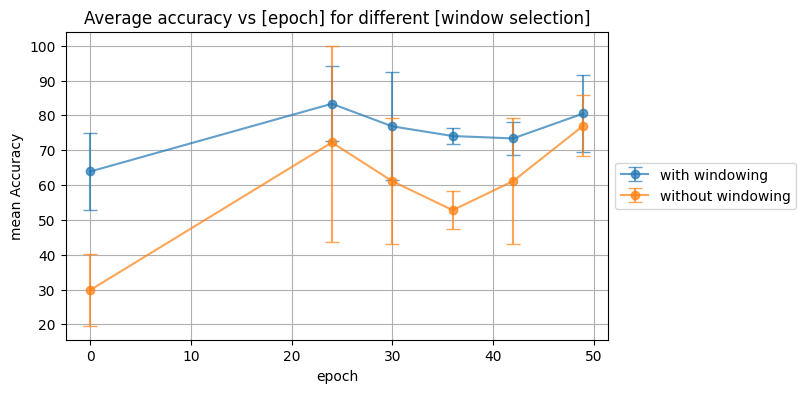

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_2_window[(case39_2_window['loss_fn']=='default')&(case39_2_window['no_sqre']=='squared')&(case39_2_window['pixel_w_step']==0)]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'window selection',filt_out,(7,4),'std','accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title=None, custom_xlabel=None, custom_ylabel=None)

In [ ]:
# filt_out={'used_regressor': ['logistic_regressor','diff_regressor']}
# all_plots_pixel(case38_0_,figsize=(5,3),points_notation=None,filter_out=filt_out,score_column='accuracy',plot_type='heatmap',agg_func='mean')

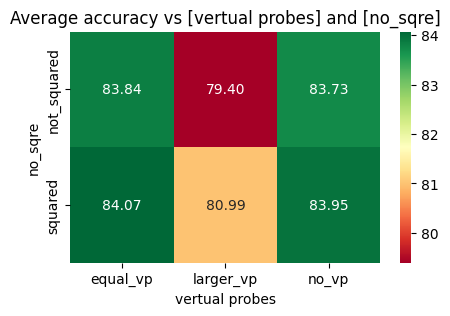

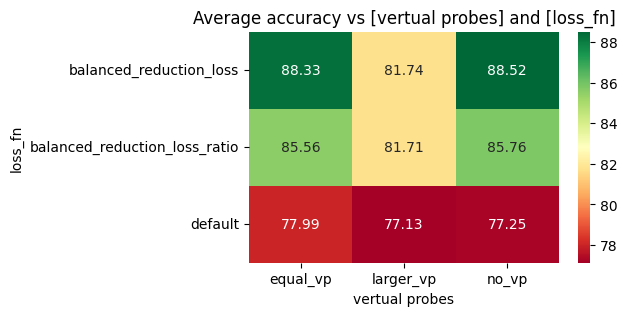

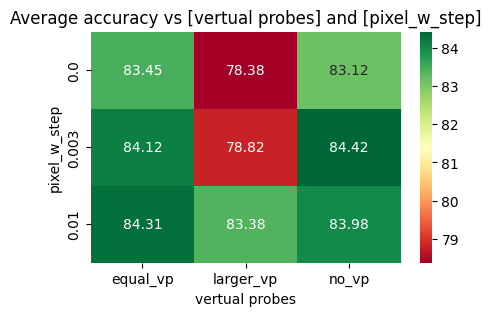

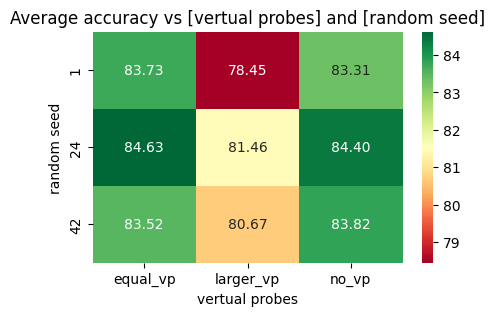

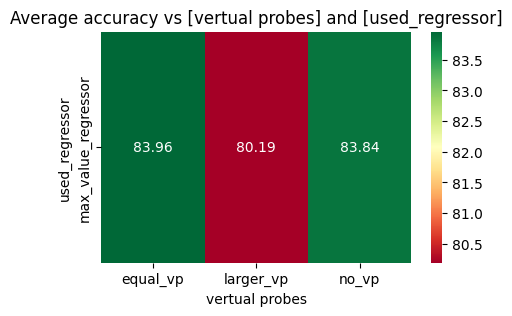

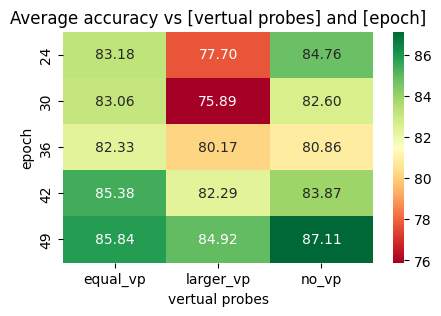

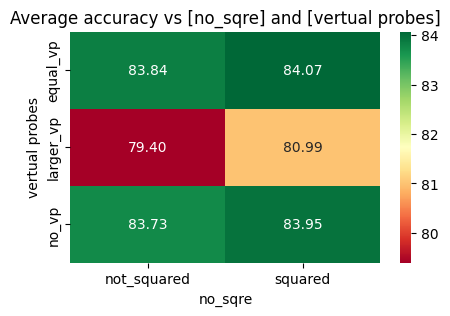

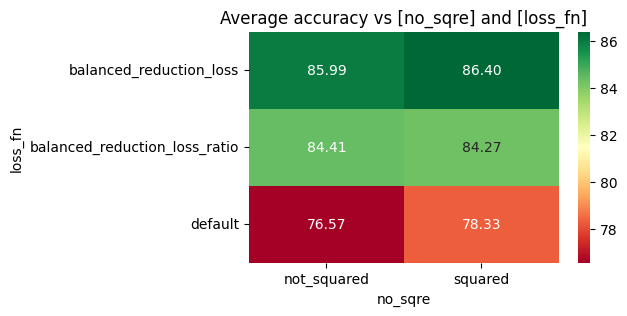

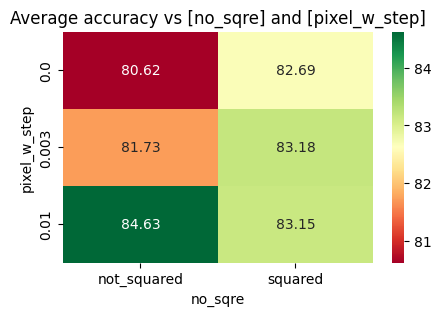

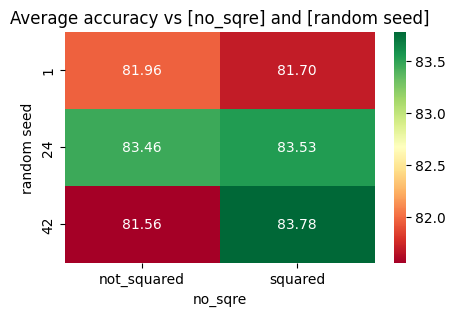

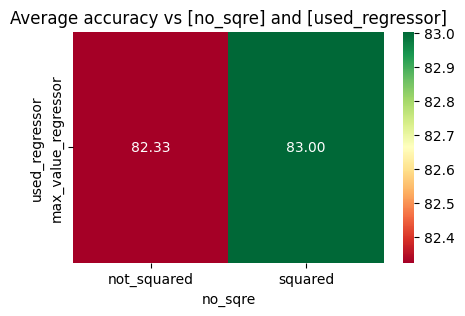

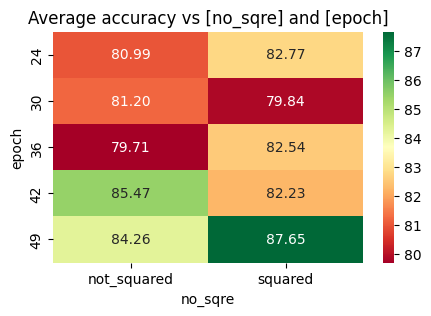

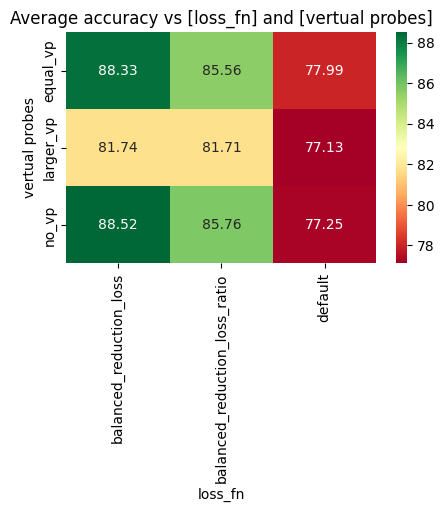

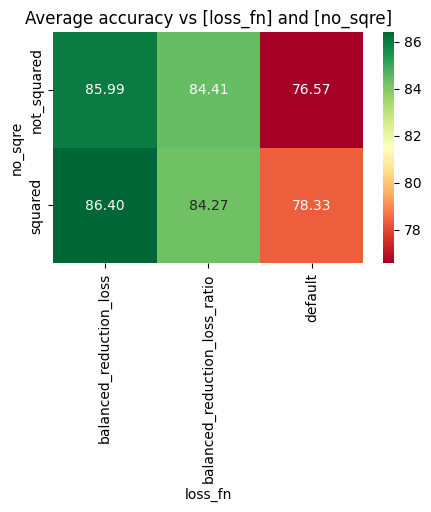

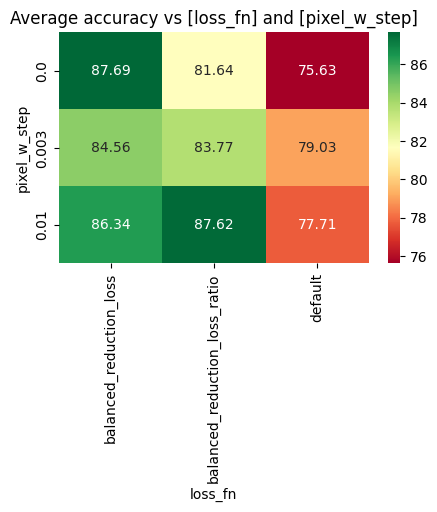

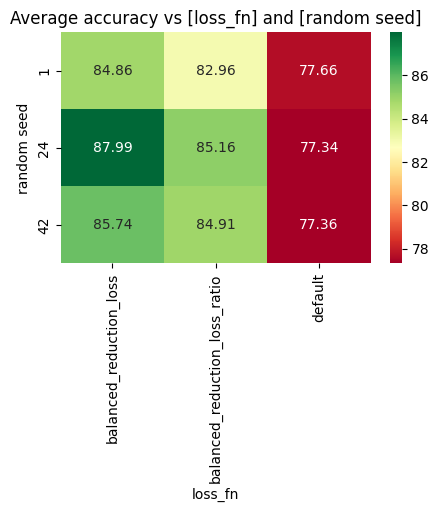

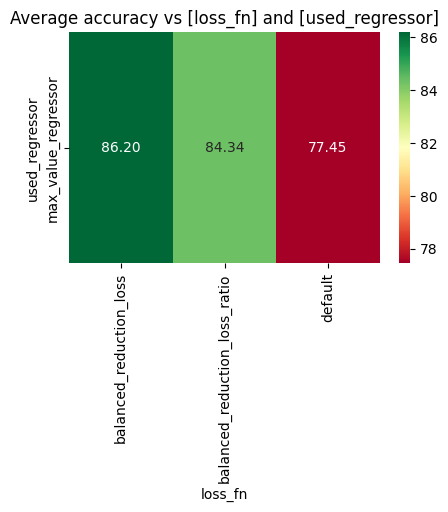

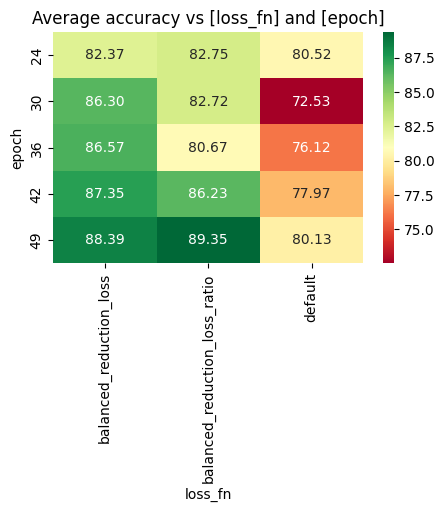

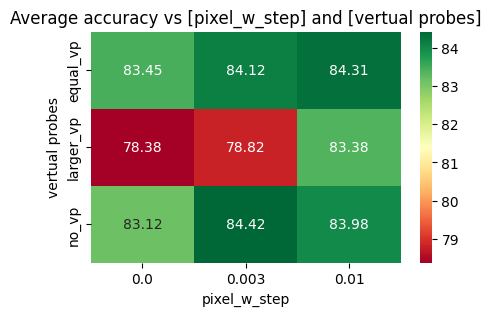

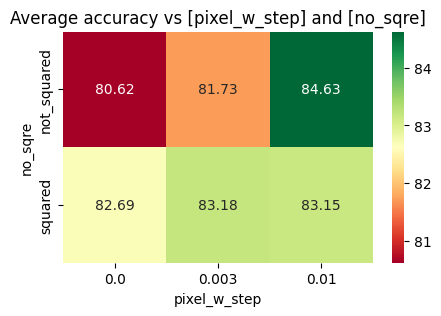

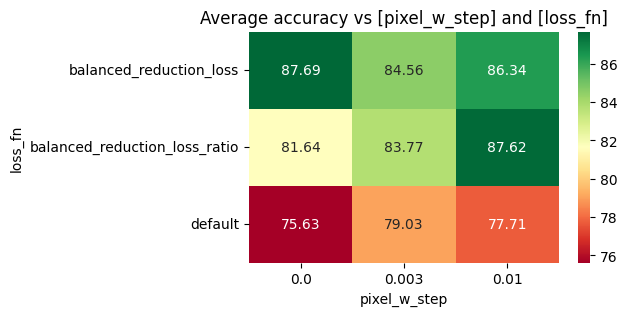

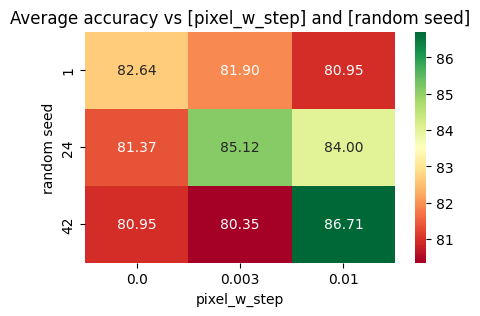

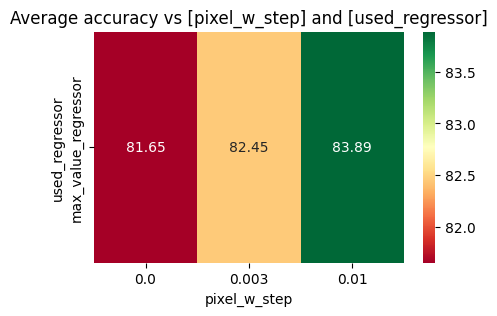

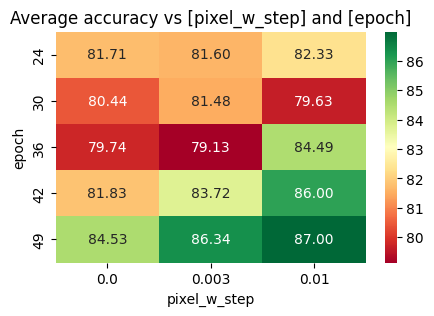

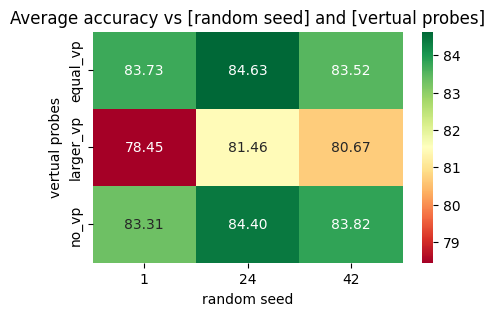

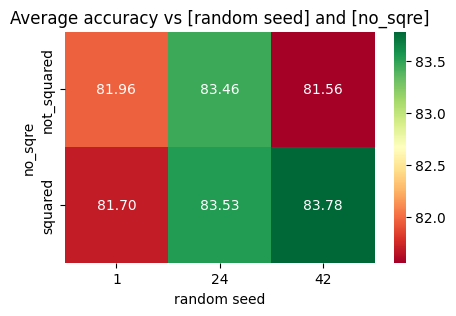

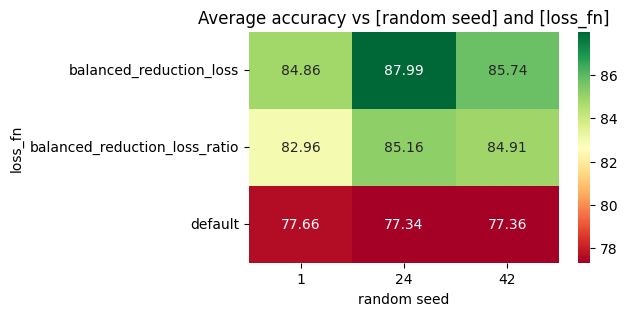

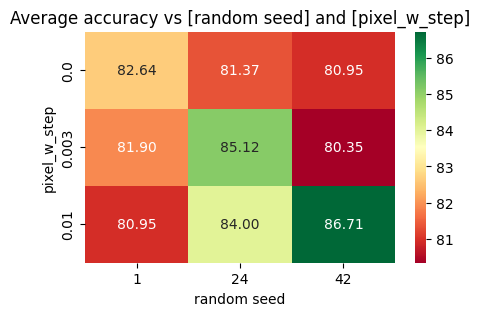

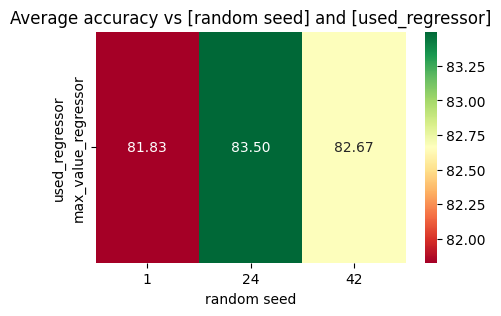

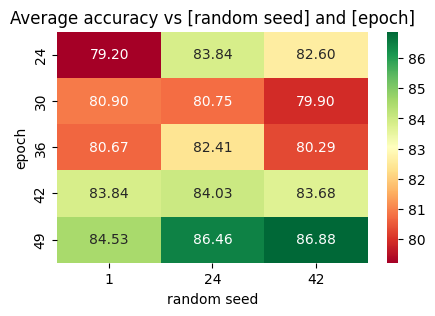

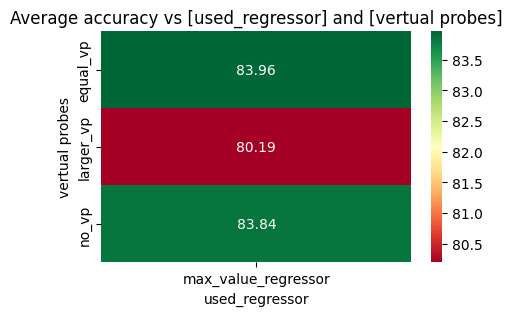

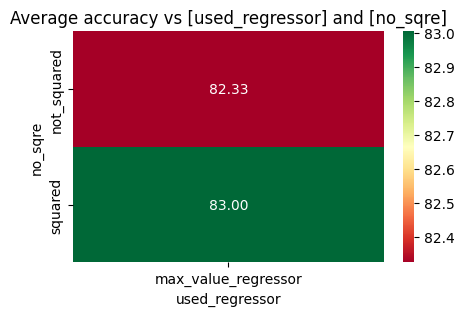

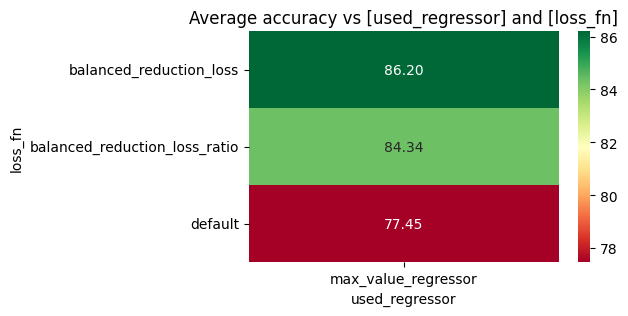

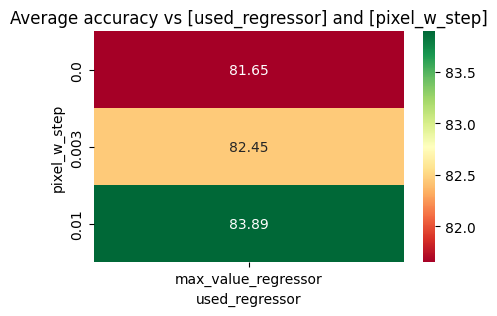

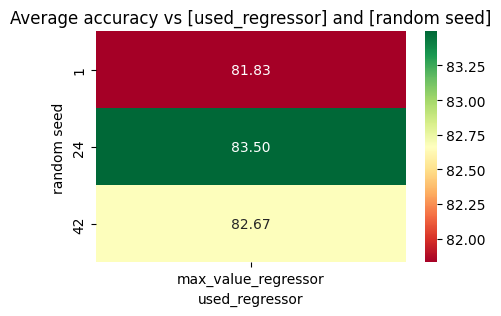

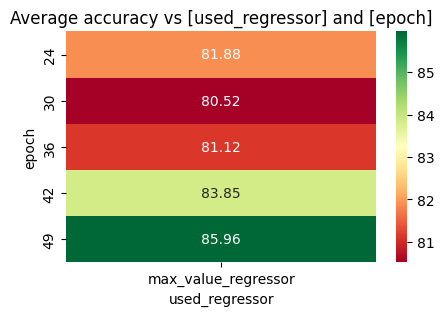

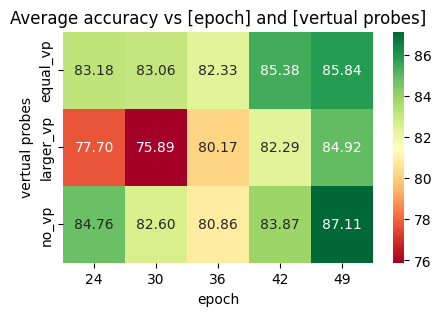

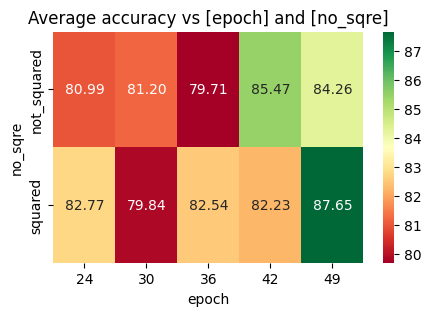

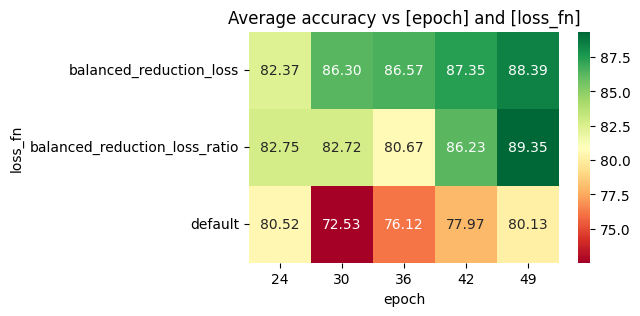

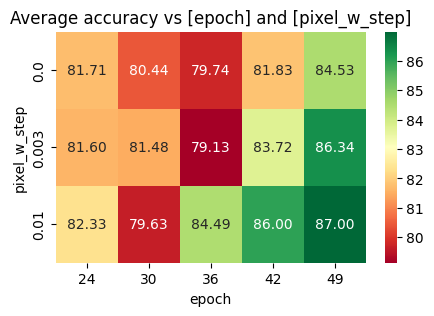

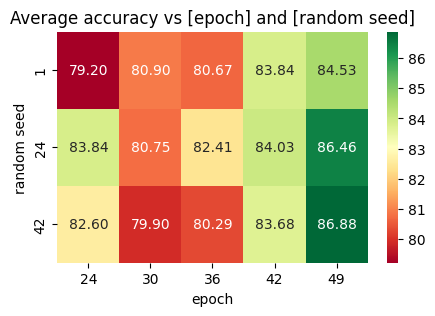

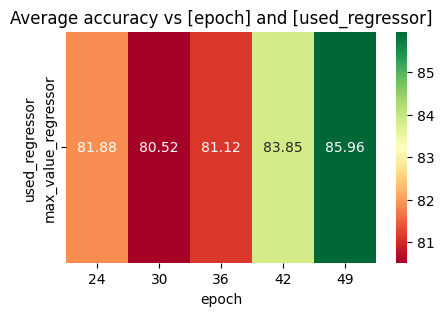

In [ ]:
filt_out={'used_regressor': ['logistic_regressor']}#,'diff_regressor']}
all_plots_pixel(case39_2_[case39_2_['epoch']!=0],figsize=(5,3),points_notation=None,filter_out=filt_out,score_column='accuracy',plot_type='heatmap',agg_func='mean')

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.


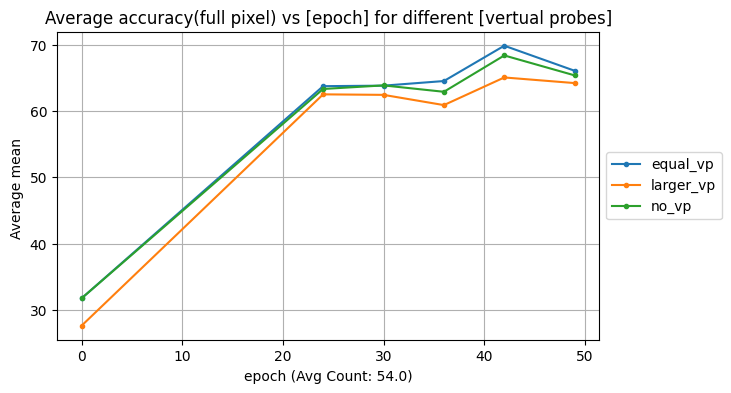

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor']}
plot_type = 'line'
plot_avg_accuracy(case39_2_, 'epoch', 'vertual probes',filt_out,figsize=(7,4),points_notation=None,score_column='accuracy(full pixel)',agg_func='mean',plot_type=plot_type)

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.


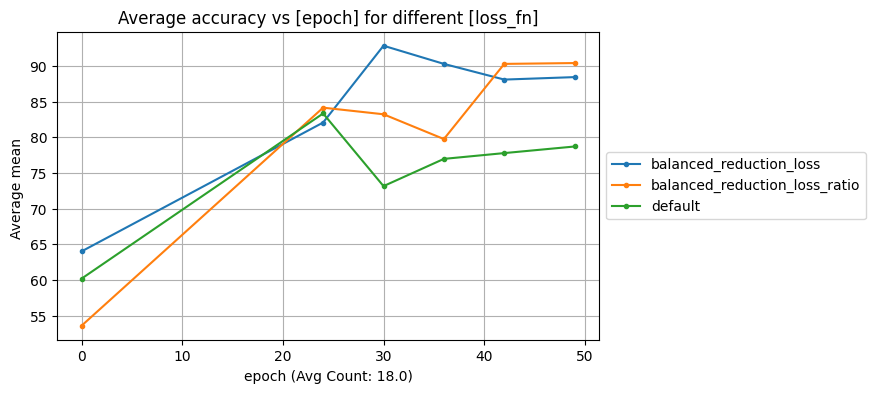

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor']}
plot_type = 'line'
plot_avg_accuracy(case39_2_, 'epoch', 'vertual probes',filt_out,figsize=(7,4),points_notation=None,score_column='accuracy',agg_func='mean',plot_type=plot_type)

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.


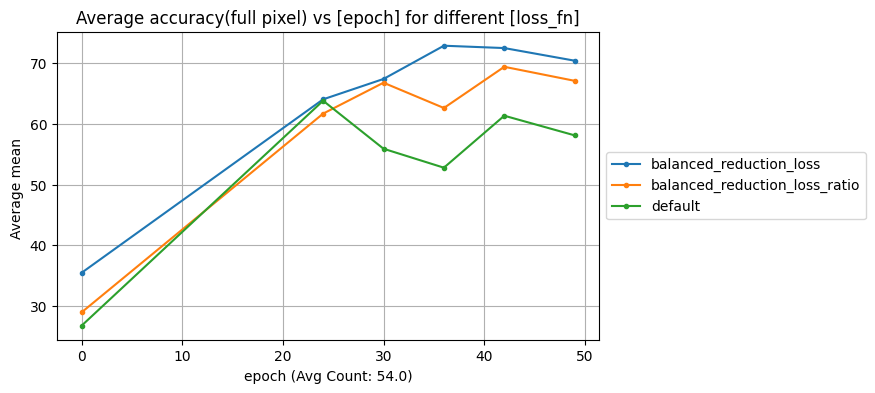

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor']}
plot_type = 'line'
plot_avg_accuracy(case39_2_, 'epoch', 'loss_fn',filt_out,figsize=(7,4),points_notation=None,score_column='accuracy(full pixel)',agg_func='mean',plot_type=plot_type)

In [ ]:
print('Full size:',162*6*2)
path = '/home/ss2722/Desktop/Big_Big_Project/HPC_related/running_files/39.3_ABBA_NP4_harder_full-rms(vp+no_sqre+pixel_w+loss_fn)_v6.52+seed/acc_results_with_info/'
case39_3_ = extract_values(path)

case39_3_.rename(columns={"v6.51_(vp": "vertual probes","seed":"random seed"}, inplace=True)
case39_3_['square_after_sum'] = case39_3_['square_after_sum'].replace({'True': 'squared', 'False': 'not_squared'})
case39_3_

Full size: 1944
data: 1944
data_full_pixel: 1944
Detected units: {}


vertual probes square_after_sum                        loss_fn  \
0             no_vp      not_squared  balanced_reduction_loss_ratio   
1             no_vp      not_squared  balanced_reduction_loss_ratio   
2             no_vp      not_squared  balanced_reduction_loss_ratio   
3             no_vp      not_squared  balanced_reduction_loss_ratio   
4             no_vp      not_squared  balanced_reduction_loss_ratio   
...             ...              ...                            ...   
1939      larger_vp      not_squared                        default   
1940      larger_vp      not_squared                        default   
1941      larger_vp      not_squared                        default   
1942      larger_vp      not_squared                        default   
1943      larger_vp      not_squared                        default   

      pixel_w_step  random seed       used_regressor  epoch  accuracy  \
0            0.010           24  max_value_regressor     49    100.00   
1            0.010           24   logistic_regressor     49    100.00   
2            0.010           24  max_value_regressor      0     50.00   
3            0.010           24   logistic_regressor      0    100.00   
4            0.010           24  max_value_regressor     42    100.00   
...            ...          ...                  ...    ...       ...   
1939         0.003           42   logistic_regressor     30    100.00   
1940         0.003           42  max_value_regressor     36     72.92   
1941         0.003           42   logistic_regressor     36    100.00   
1942         0.003           42  max_value_regressor     24     50.00   
1943         0.003           42   logistic_regressor     24    100.00   

      accuracy(full pixel)  
0                     75.0  
1                    100.0  
2                     25.0  
3                    100.0  
4                     75.0  
...                    ...  
1939                 100.0  
1940                  50.0  
1941                 100.0  
1942                  37.5  
1943                 100.0  

[1944 rows x 9 columns]

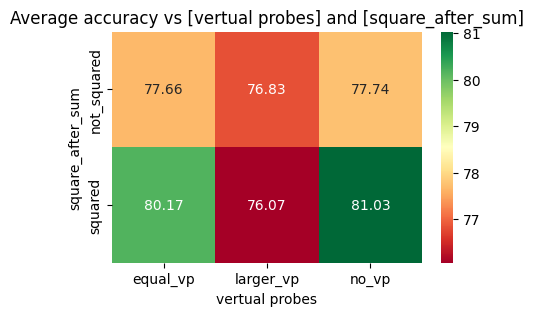

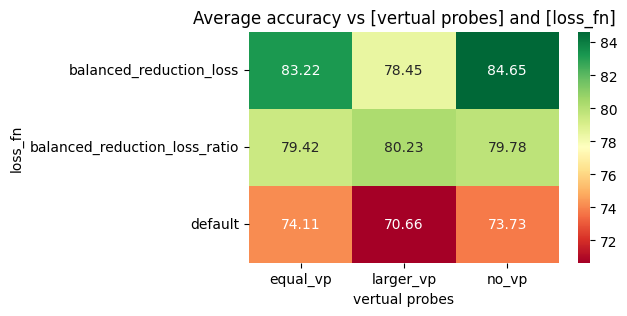

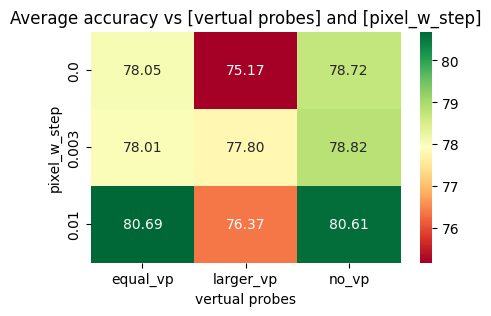

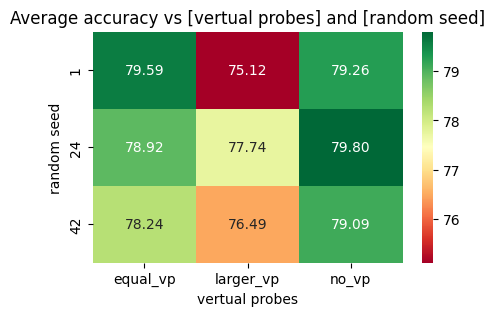

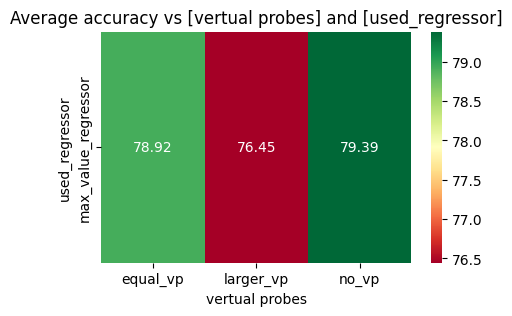

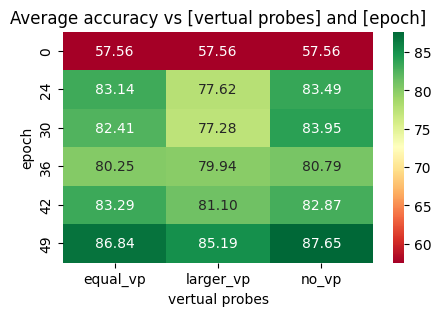

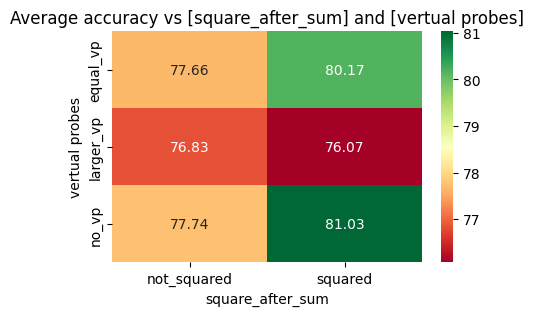

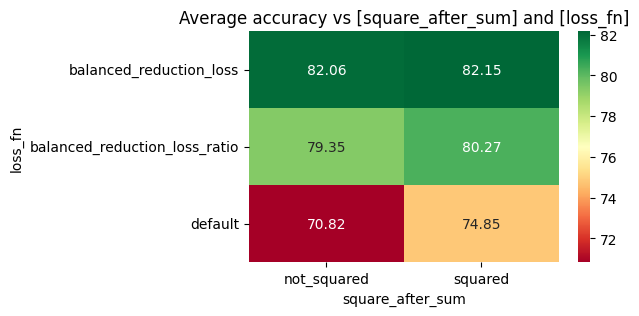

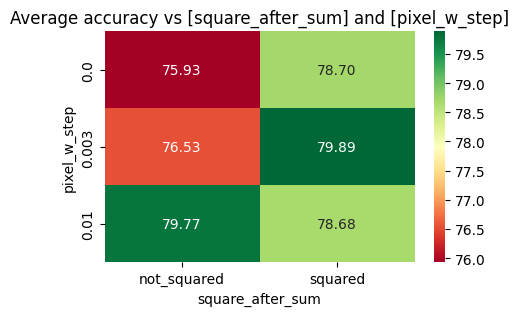

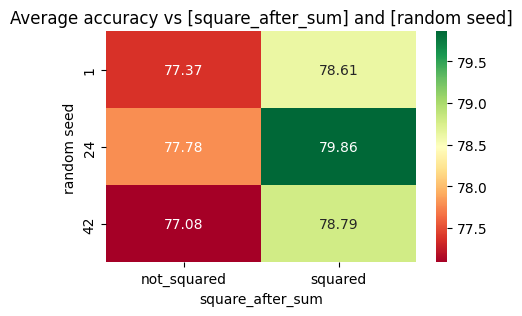

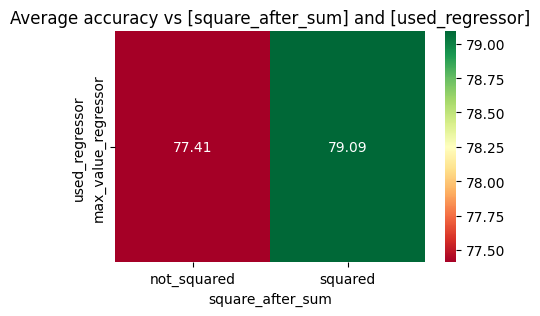

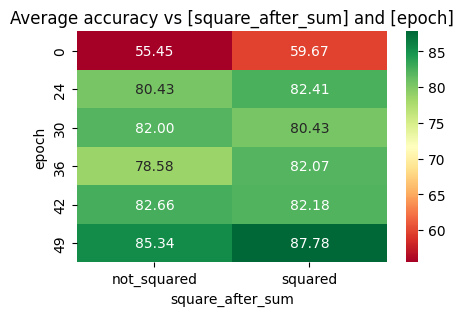

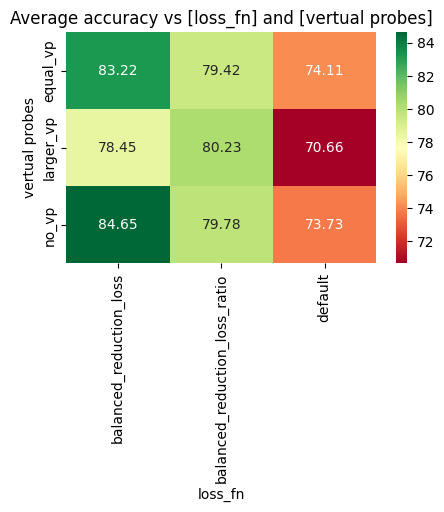

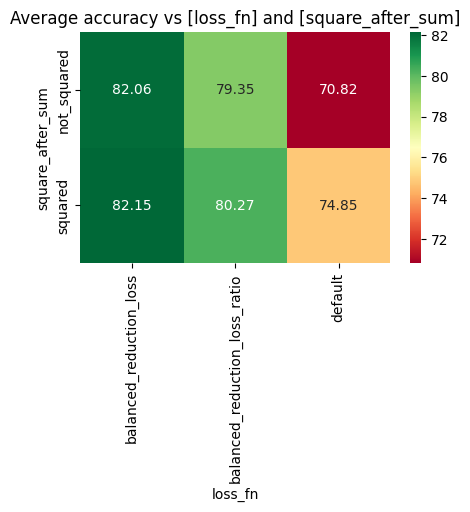

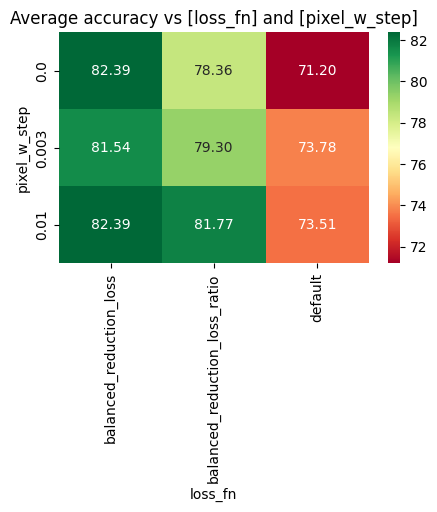

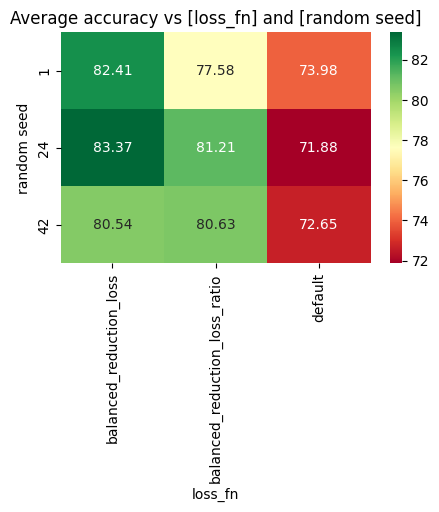

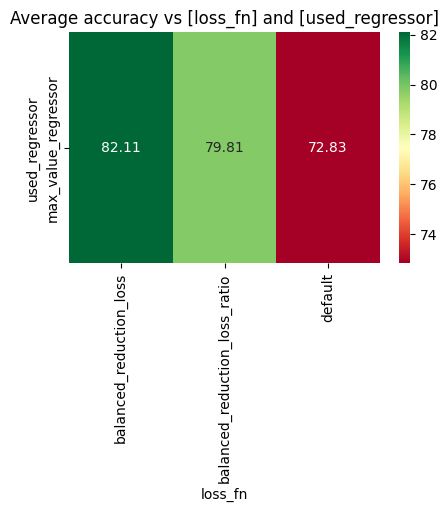

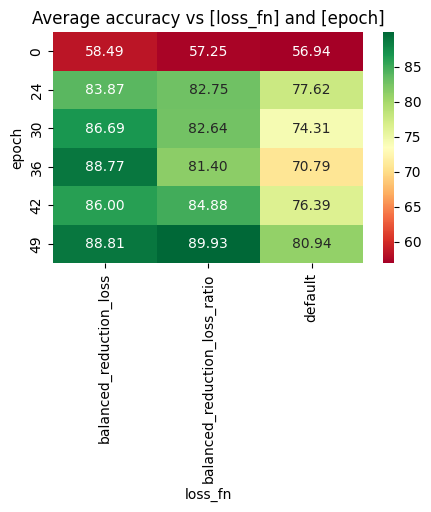

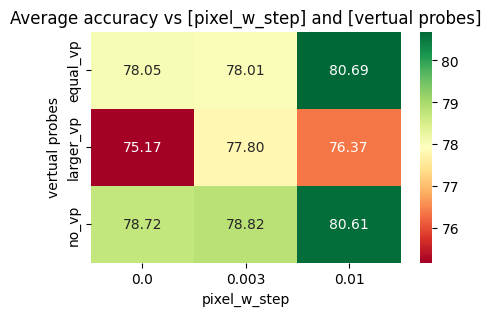

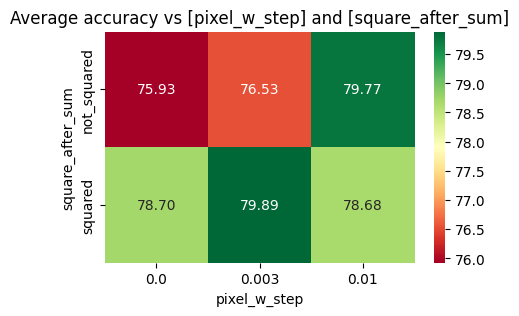

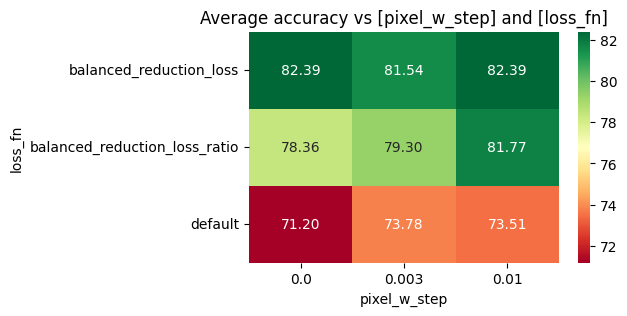

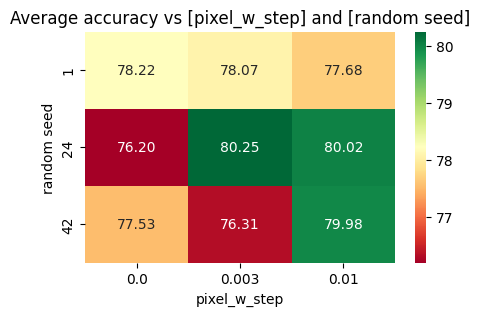

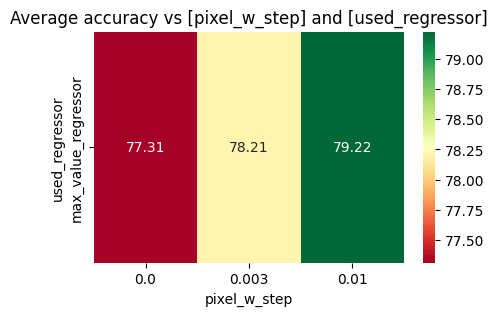

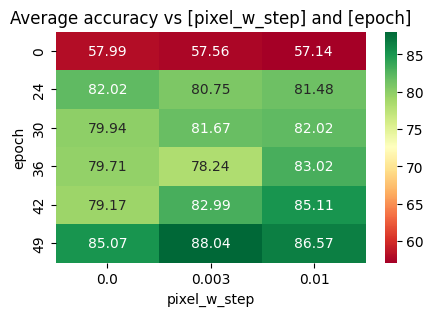

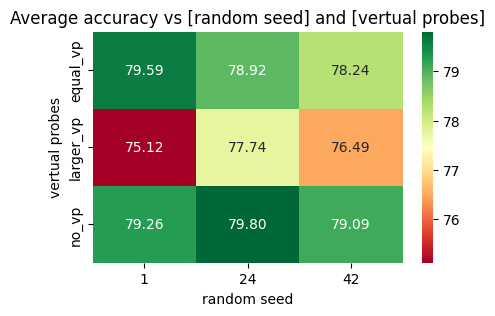

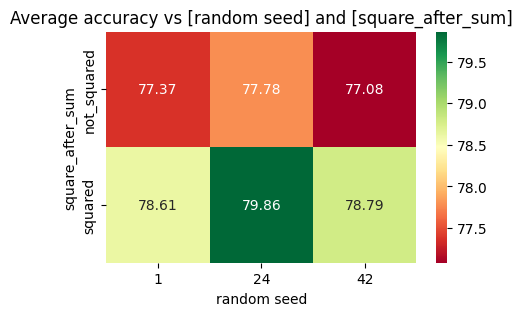

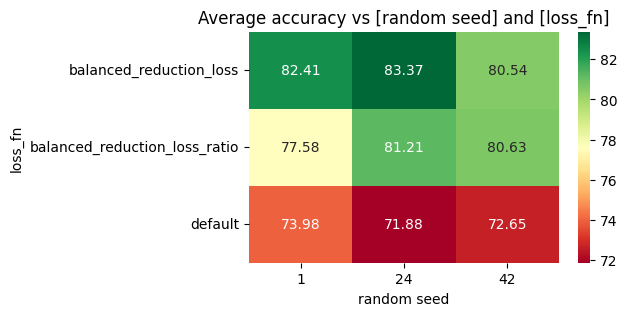

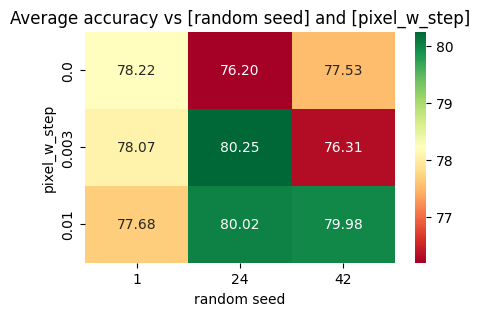

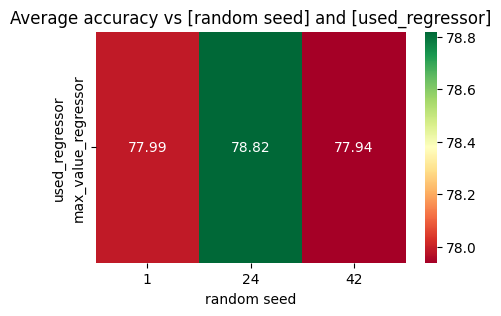

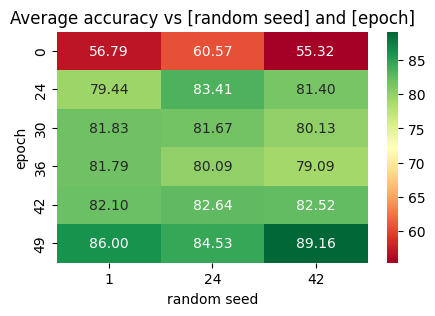

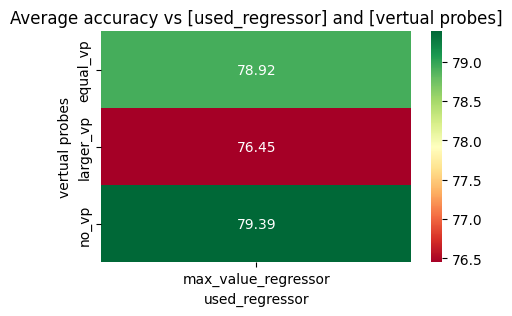

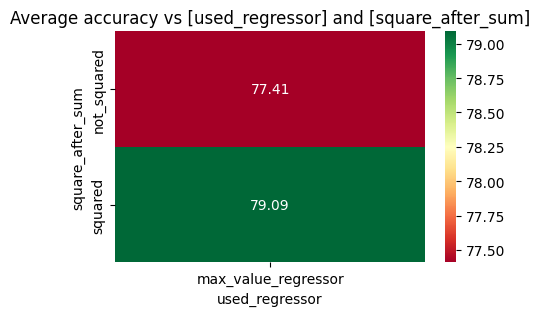

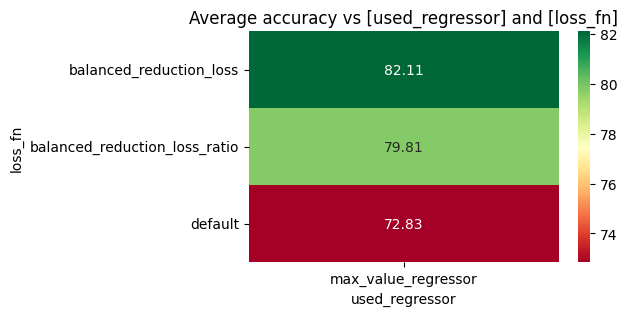

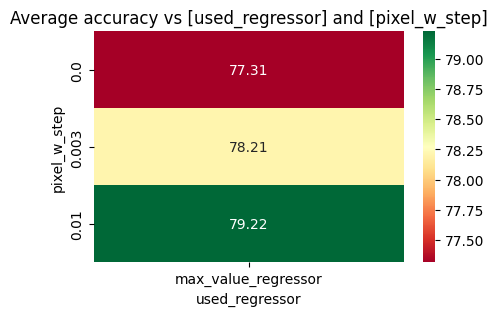

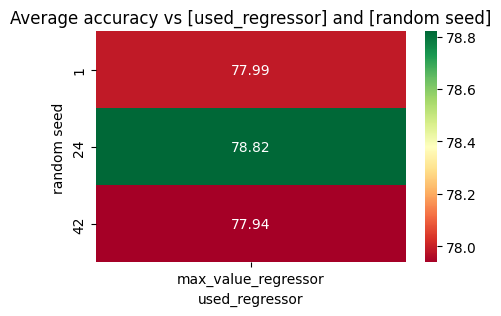

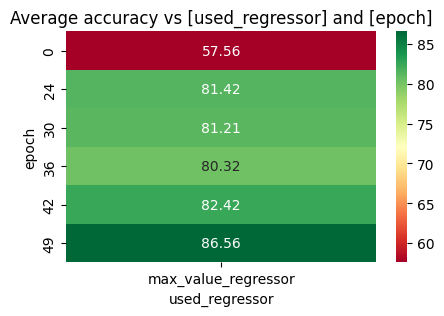

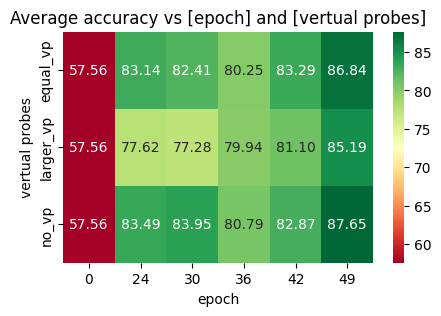

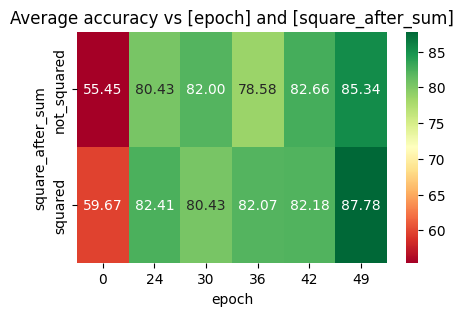

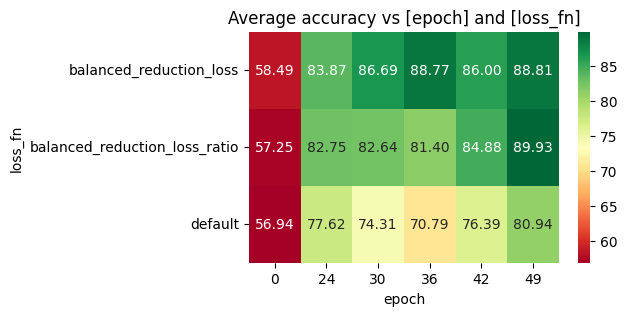

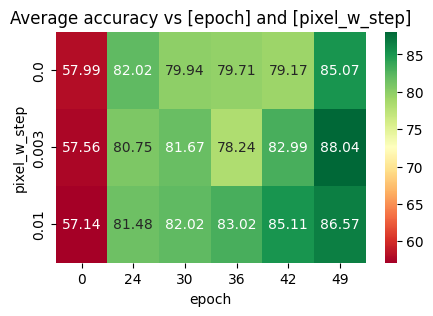

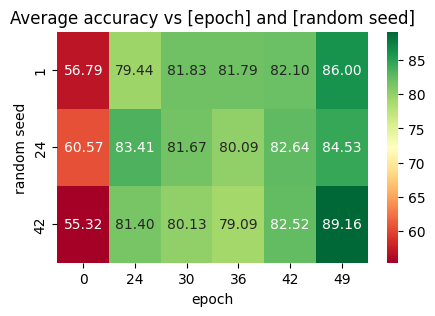

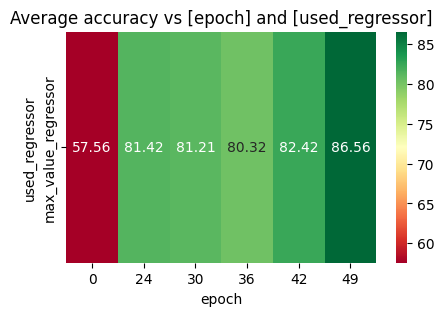

In [ ]:
filt_out={'used_regressor': ['logistic_regressor']}#,'diff_regressor']}
all_plots_pixel(case39_3_,figsize=(5,3),points_notation=None,filter_out=filt_out,score_column='accuracy',plot_type='heatmap',agg_func='mean')

In [ ]:
print('Full size:',108*6*2)
path = '/home/ss2722/Desktop/Big_Big_Project/HPC_related/running_files/39.4_ABBA_NP4_harder_full-rms(vp+no_sqre+pixel_w+more-loss_fn)_v6.52.1/acc_results_with_info/'
case39_4_ = extract_values(path)

case39_4_.rename(columns={"v6.51_(vp": "vertual probes","seed":"random seed"}, inplace=True)
case39_4_['square_after_sum'] = case39_4_['square_after_sum'].replace({'squared': 'True', 'not_squared': 'False'})
case39_4_

Full size: 1296
data: 1292
data_full_pixel: 1292
Detected units: {}


vertual probes square_after_sum                  loss_fn  pixel_w_step  \
0             no_vp             True                 nll_loss         0.003   
1             no_vp             True                 nll_loss         0.003   
2             no_vp             True                 nll_loss         0.003   
3             no_vp             True                 nll_loss         0.003   
4             no_vp             True                 nll_loss         0.003   
...             ...              ...                      ...           ...   
1287       equal_vp             True  balanced_reduction_loss         0.010   
1288       equal_vp             True  balanced_reduction_loss         0.010   
1289       equal_vp             True  balanced_reduction_loss         0.010   
1290       equal_vp             True  balanced_reduction_loss         0.010   
1291       equal_vp             True  balanced_reduction_loss         0.010   

           used_regressor  epoch  accuracy  accuracy(full pixel)  
0     max_value_regressor     49     100.0                 50.00  
1      logistic_regressor     49     100.0                100.00  
2     max_value_regressor      0      50.0                 25.00  
3      logistic_regressor      0     100.0                100.00  
4     max_value_regressor     42      75.0                 66.67  
...                   ...    ...       ...                   ...  
1287   logistic_regressor     30     100.0                100.00  
1288  max_value_regressor     36      75.0                 75.00  
1289   logistic_regressor     36     100.0                100.00  
1290  max_value_regressor     24      75.0                 75.00  
1291   logistic_regressor     24     100.0                100.00  

[1292 rows x 8 columns]

In [ ]:
filt_out={'used_regressor': ['logistic_regressor']}#,'diff_regressor']}
all_plots_pixel(case39_4_,figsize=(5,3),points_notation=None,filter_out=filt_out,score_column='accuracy',plot_type='heatmap',agg_func='mean')

NameError: name 'case39_4_' is not defined

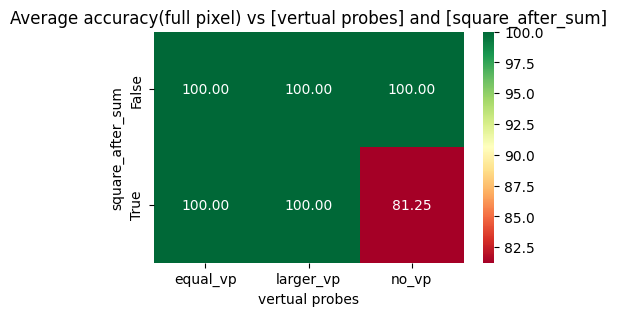

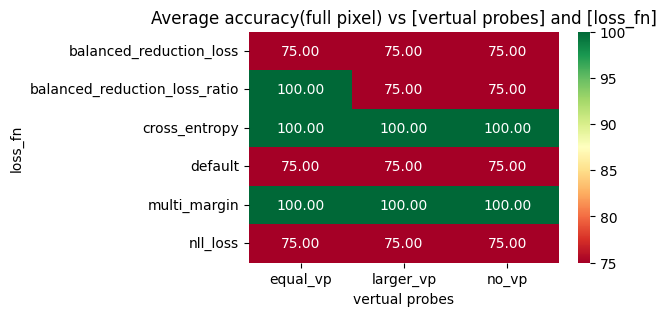

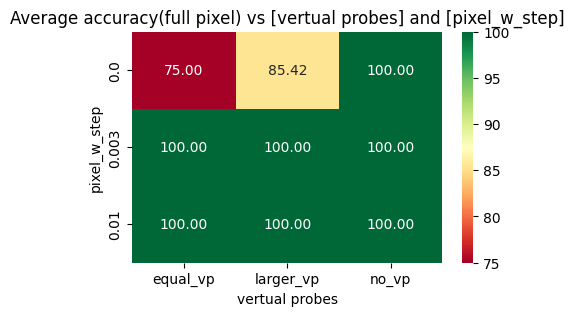

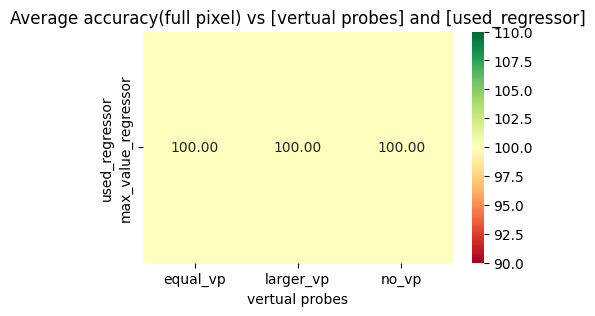

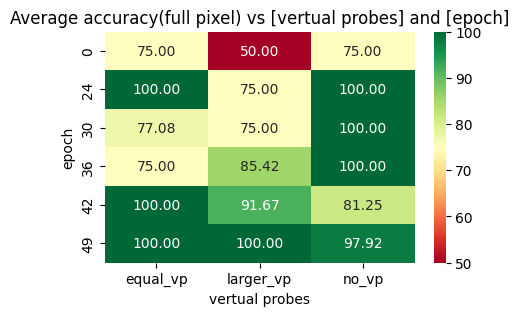

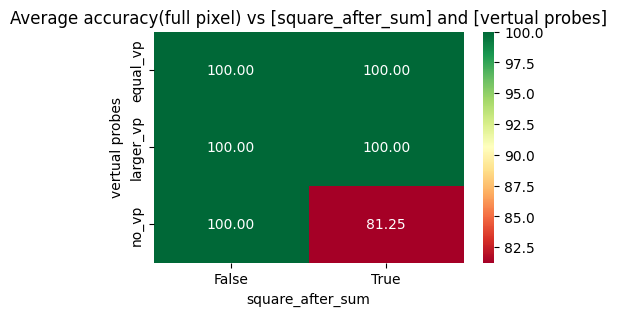

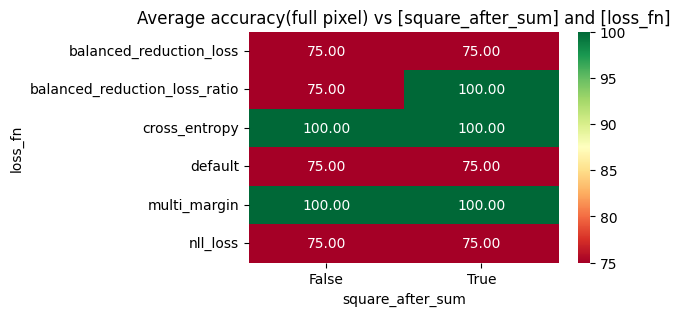

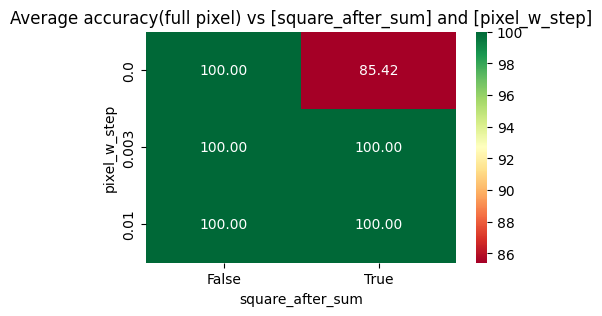

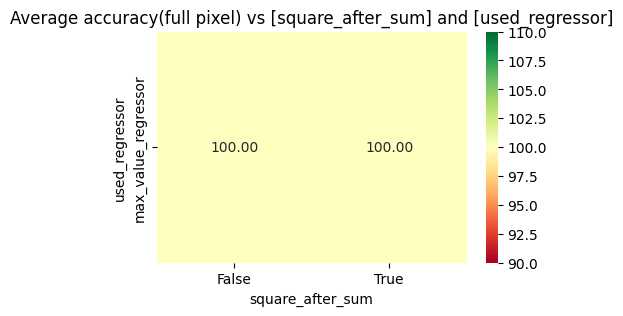

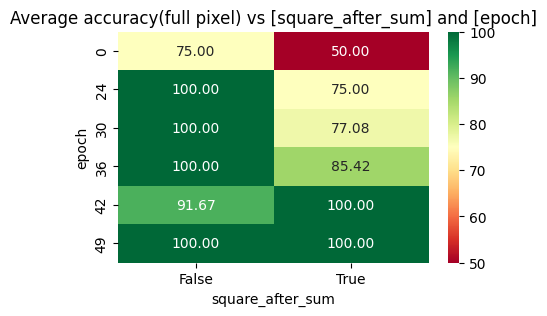

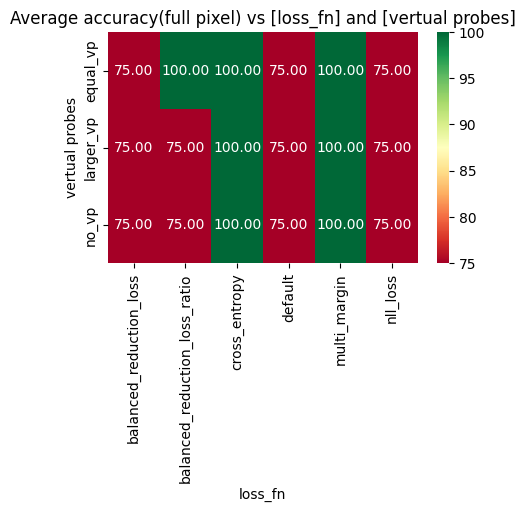

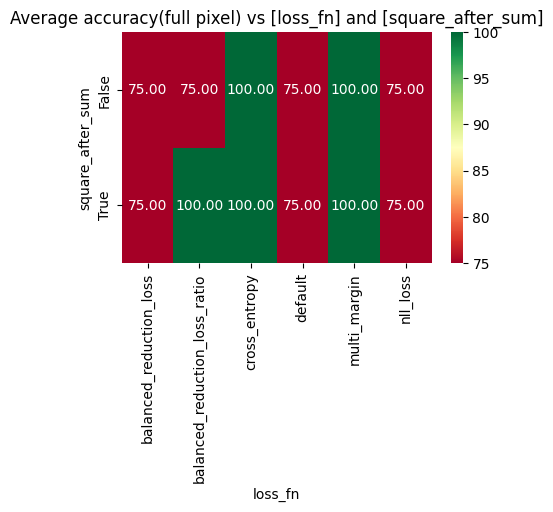

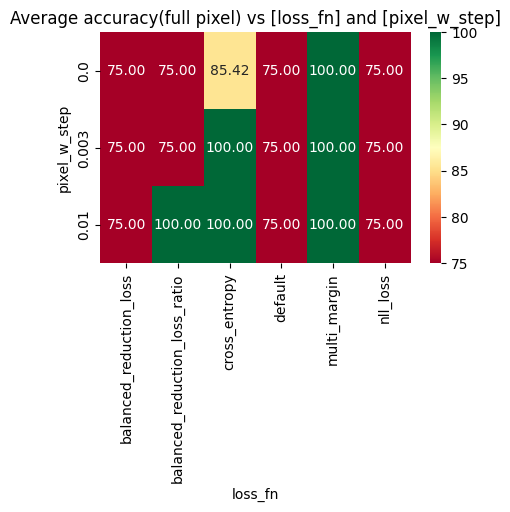

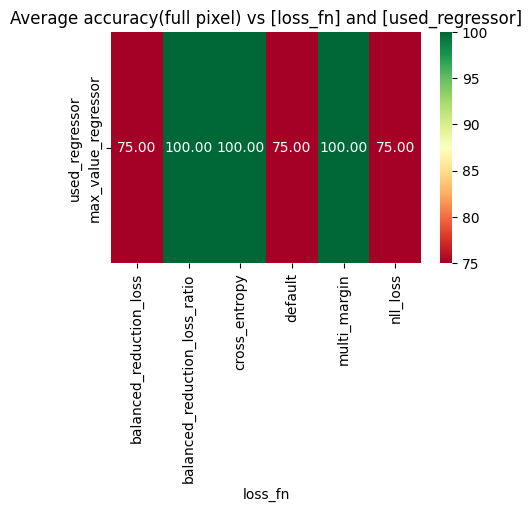

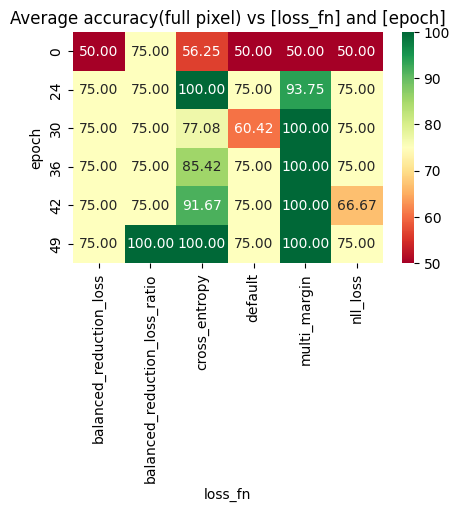

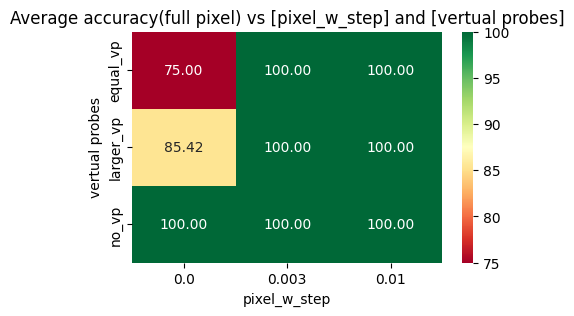

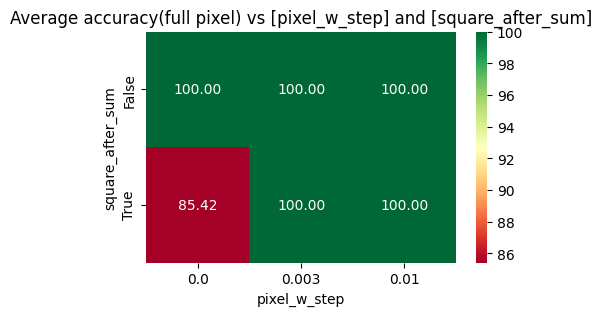

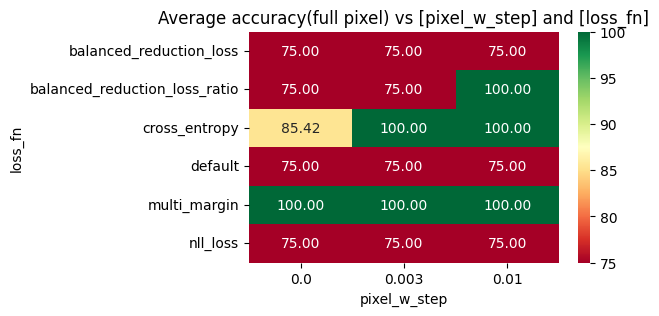

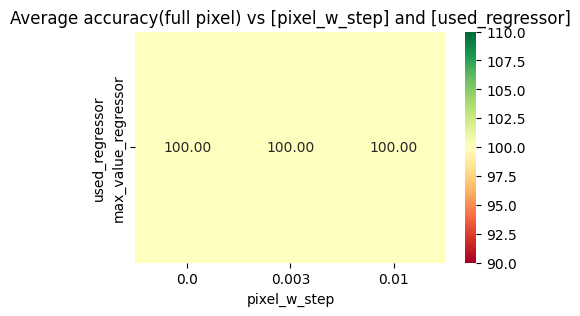

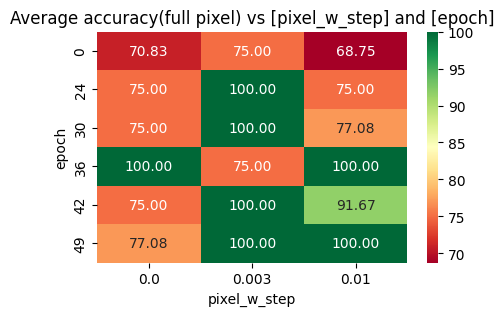

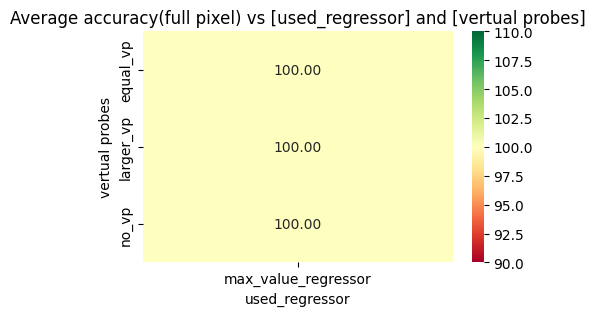

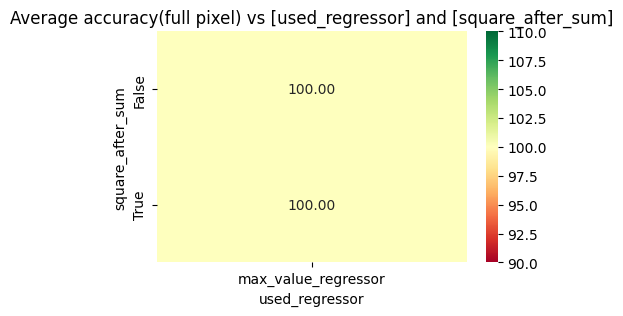

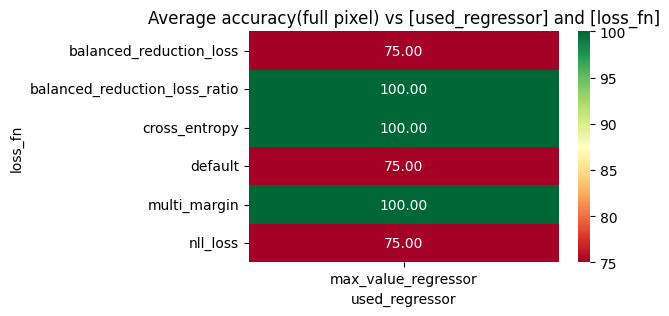

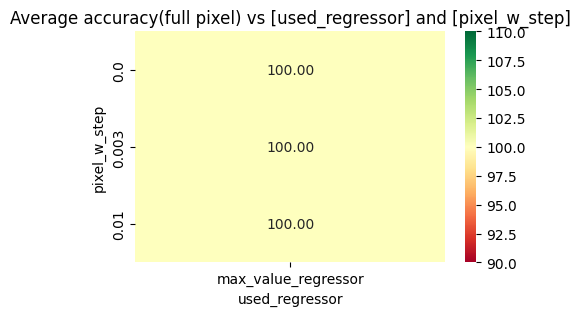

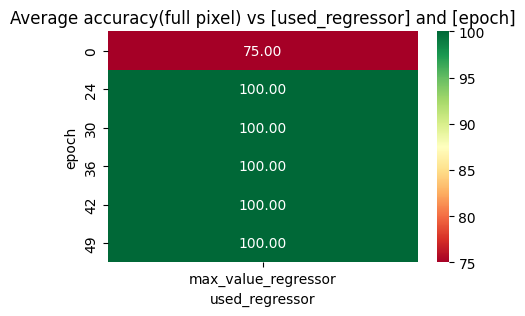

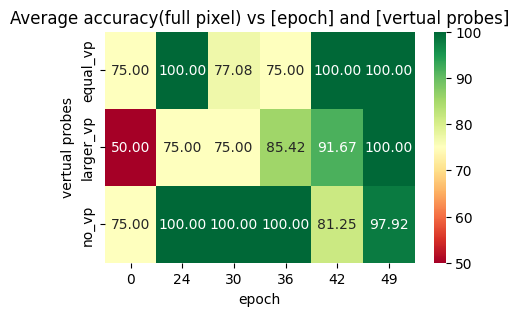

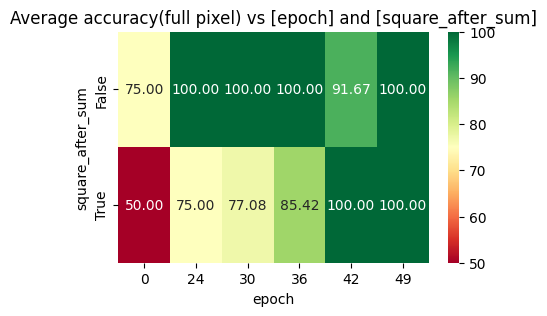

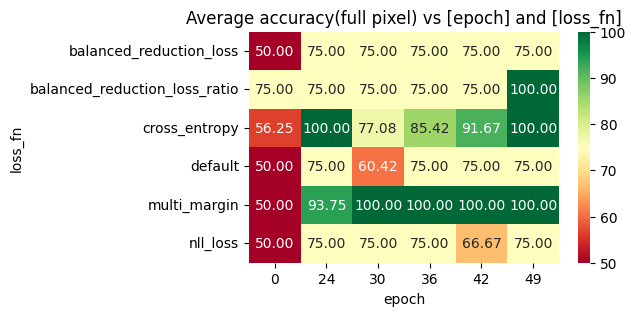

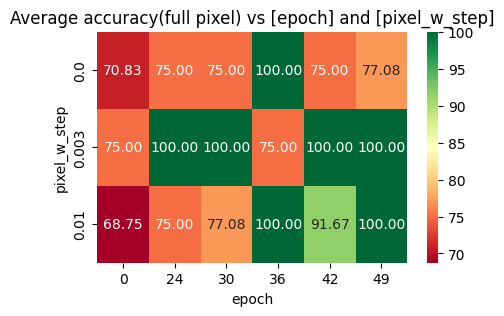

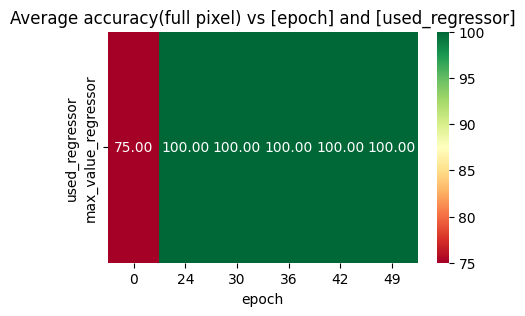

In [ ]:
filt_out={'used_regressor': ['logistic_regressor']}#,'diff_regressor']}
all_plots_pixel(case39_4_,figsize=(5,3),points_notation=None,filter_out=filt_out,score_column='accuracy(full pixel)',plot_type='heatmap',agg_func='max')

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.


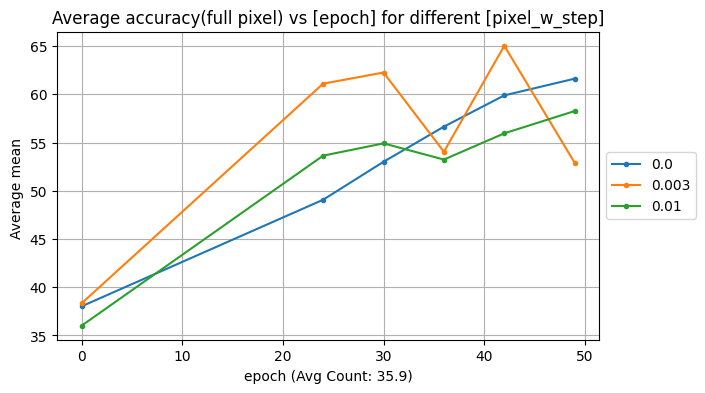

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor']}
plot_type = 'line'
plot_avg_accuracy(case39_4_, 'epoch', 'pixel_w_step',filt_out,figsize=(7,4),points_notation=None,score_column='accuracy(full pixel)',agg_func='mean',plot_type=plot_type)

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.


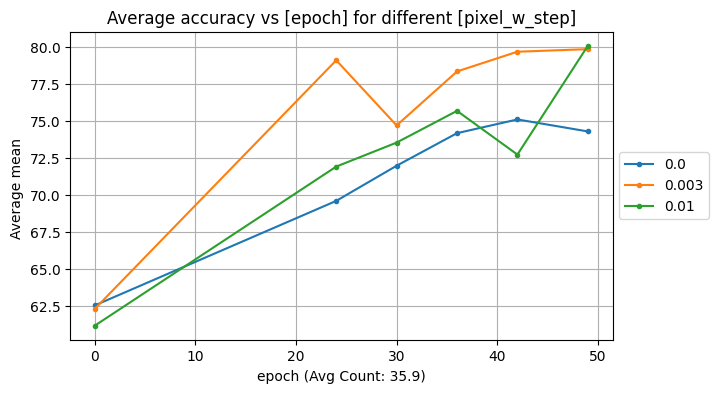

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor']}
plot_type = 'line'
plot_avg_accuracy(case39_4_, 'epoch', 'pixel_w_step',filt_out,figsize=(7,4),points_notation=None,score_column='accuracy',agg_func='mean',plot_type=plot_type)

In [ ]:
case39_4_window=expand_dataframe(case39_4_)

case39_4_window['square_after_sum'] = case39_4_window['square_after_sum'].replace({'True': 'squared', 'False': 'not_squared'})
case39_4_window

vertual probes square_after_sum                  loss_fn  pixel_w_step  \
0             no_vp          squared                 nll_loss         0.003   
1             no_vp          squared                 nll_loss         0.003   
2             no_vp          squared                 nll_loss         0.003   
3             no_vp          squared                 nll_loss         0.003   
4             no_vp          squared                 nll_loss         0.003   
...             ...              ...                      ...           ...   
2579       equal_vp          squared  balanced_reduction_loss         0.010   
2580       equal_vp          squared  balanced_reduction_loss         0.010   
2581       equal_vp          squared  balanced_reduction_loss         0.010   
2582       equal_vp          squared  balanced_reduction_loss         0.010   
2583       equal_vp          squared  balanced_reduction_loss         0.010   

           used_regressor  epoch  accuracy  accuracy(full pixel)  \
0     max_value_regressor     49     100.0                 50.00   
1      logistic_regressor     49     100.0                100.00   
2     max_value_regressor      0      50.0                 25.00   
3      logistic_regressor      0     100.0                100.00   
4     max_value_regressor     42      75.0                 66.67   
...                   ...    ...       ...                   ...   
2579   logistic_regressor     30     100.0                100.00   
2580  max_value_regressor     36      75.0                 75.00   
2581   logistic_regressor     36     100.0                100.00   
2582  max_value_regressor     24      75.0                 75.00   
2583   logistic_regressor     24     100.0                100.00   

       window selection  
0        with windowing  
1        with windowing  
2        with windowing  
3        with windowing  
4        with windowing  
...                 ...  
2579  without windowing  
2580  without windowing  
2581  without windowing  
2582  without windowing  
2583  without windowing  

[2584 rows x 9 columns]

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'xmax_value_regressor' not found in column 'used_regressor'. Skipping this condition.


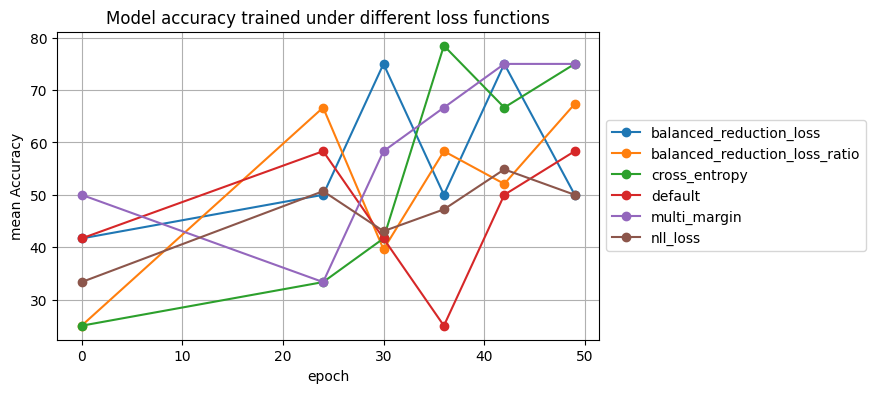

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor','xmax_value_regressor']}
plot_type = 'line'
data=case39_4_window[(case39_4_window['window selection']=='without windowing')&(case39_4_window['square_after_sum']=='squared')&(case39_4_window['pixel_w_step']==0)]
#data=case39_1_
plot_avg_accuracy(data, 'epoch', 'loss_fn',filt_out,(7,4),None,'accuracy',agg_func='mean',a=0,b=1,plot_type=plot_type, custom_title='Model accuracy trained under different loss functions', custom_xlabel=None, custom_ylabel=None)

Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.


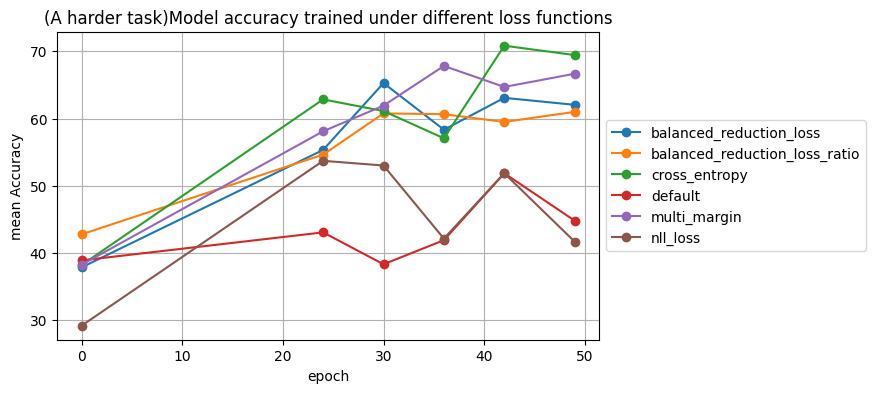

In [ ]:
filt_out={'used_regressor': ['logistic_regressor','diff_regressor']}
plot_type = 'line'
plot_avg_accuracy(case39_4_, 'epoch', 'loss_fn',filt_out,figsize=(7,4),points_notation=None,score_column='accuracy(full pixel)',a=0,b=1,agg_func='mean',custom_title='(A harder task)Model accuracy trained under different loss functions',plot_type=plot_type)

# pixel method visualization

In [ ]:
def extract_params(directory_name, units):
    # Split the directory_name and construct the parameter dictionary directly
    params_dict = {}
    first_part_params = directory_name.split(',')
    for param in first_part_params:
        name, val = param.split('=')
        
        # Remove square brackets from the value
        val = val.replace('[', '').replace(']', '')

        # Extract numeric part of the value using regex
        numeric_val = re.search(r'-?\d+\.?\d*', val)
        if numeric_val:
            params_dict[name] = numeric_val.group()
            # Storing the unit separately in the units dictionary
            unit = re.search(r'[a-zA-Z]+$', val)
            if unit and name not in units:
                units[name] = unit.group()
        else:
            # In case the value is not numeric (like 'method'), just save it directly
            params_dict[name] = val
    return params_dict, units

def clean_file_name_pixels(file):
    # Remove the prefix and suffix
    filename = file.replace("model_acc_for_diff_pixel_", "").replace(".txt", "")
    
    # The remaining part is the regressor type
    return filename

def read_file_data(file_path):
    # Open the file as a text file
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Initialize a list to store each row as a dictionary
    rows = []
    
    # Skip the first two lines, and process the rest
    for line in lines[2:]:
        row = {}

        # Extract the values using string processing or regex methods
        # The regex pattern captures two accuracy percentages and three pixel values from each line
        match = re.search(r'validation acc:(\d+\.\d+)%, test acc:(\d+\.\d+)%, pixel:\[(\d+), (\d+), (\d+)\]', line)
        if match:

            row['pixel_start_pos'] = match.group(3)
            row['pixel_size'] = match.group(4)
            row['pixel_avail'] = match.group(5)
            row['validation_acc'] = match.group(1)
            row['test_acc'] = match.group(2)
        
            rows.append(row)
    
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(rows)
    
    return df

def combine_params_and_data(params_dict, df):
    for key in params_dict:
        df[key] = params_dict[key]
    return df

def extract_pixels_value(main_path):
    # Prepare an empty DataFrame to store data
    data = pd.DataFrame()

    # Initialize dictionary to store units
    units = {}

    # Loop through each directory
    for root, dirs, _ in tqdm(os.walk(main_path)):
        # Check if the specific subdirectory is in the directory
        for directory in dirs:
            match = re.match(r"model_test_e(\d+)$", directory)
            if match:
                model_number = match.group(1)
                model_dir = os.path.join(root, directory)

                # Iterate over files in the model directory
                for _, _, files in os.walk(model_dir):
                    for file in files:
                        if re.search(r'model_acc_for_diff_pixel_.*\.txt$', file):
                            file_path = os.path.join(model_dir, file)

                            # Check if the specific file is in the subdirectory
                            if os.path.exists(file_path):
                                directory_name = re.search(r"\((.*?)\)", os.path.basename(root)).group(1)
                                params_dict, units = extract_params(directory_name, units)
                                params_dict['used_regressor'] = clean_file_name_pixels(file)
                                params_dict['epoch'] = model_number

                                # Read data from the file
                                df = read_file_data(file_path)

                                # Combine params_dict with df
                                df = combine_params_and_data(params_dict, df)

                                # Append df to data
                                data = pd.concat([data, df], ignore_index=True)

    # Sort the columns of the DataFrame
    data = data.apply(pd.to_numeric, errors='ignore')
    sorted_columns = sorted(data.columns.tolist(), key=lambda x: x not in params_dict)
    data = data[sorted_columns]

    # Print detected units
    print('Detected units:', units)
    data['validation_acc']=pd.to_numeric(data['validation_acc'])
    data['test_acc']=pd.to_numeric(data['test_acc'])
    return data


In [ ]:
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# import numpy as np
# from matplotlib.colors import LinearSegmentedColormap

# def darken_cmap(cmap):
#     cmap = cm.get_cmap(cmap)
#     cmap_data = cmap(np.arange(cmap.N))
    
#     # change the first RGB columns in each row (which form the colors) by taking
#     # half their current value, effectively darkening the colormap
#     cmap_data[:, :3] = cmap_data[:, :3] * 0.8
    
#     return LinearSegmentedColormap.from_list('darkened_' + cmap.name, cmap_data, cmap.N)

# def plot_avg_accuracy(df, x_param, line_param, filter_out=None, figsize=(10,6), points_notation=None,score_column='accuracy'):
#     # Apply the filter condition if provided
#     if filter_out:
#         for column, conditions in filter_out.items():
#             if column not in df.columns:
#                 print(f"Column '{column}' not found in dataframe. Skipping this filter.")
#                 continue

#             if not isinstance(conditions, list):
#                 conditions = [conditions]

#             for condition in conditions:
#                 if condition not in df[column].unique():
#                     print(f"Condition '{condition}' not found in column '{column}'. Skipping this condition.")
#                     continue

#                 df = df[df[column] != condition]


#     # Calculate average accuracy and standard deviation grouped by x_param and line_param
#     grouped = df.groupby([x_param, line_param]).agg({score_column: ['mean', 'std', 'size']}).reset_index()

#     # Flatten the multi-level columns
#     grouped.columns = ['_'.join(t).rstrip('_') for t in grouped.columns.values]

#     # Rename columns for convenience
#     grouped = grouped.rename(columns={f"{score_column}_mean": score_column, f"{score_column}_std": "std", f"{score_column}_size": "counts"})

#     # Get unique line parameters
#     unique_lines = grouped[line_param].unique()

#     # Calculate the average count
#     avg_count = grouped['counts'].mean()

#     # Create a colormap and normalize object
#     cmap = darken_cmap('RdYlGn_r') # '_r' indicates reverse order, so high values will be red and low values green
#     norm = colors.Normalize(vmin=5, vmax=20) # values <=5 will be most green, >=20 will be most red

#     # Create a new figure
#     plt.figure(figsize=figsize)

#     # Loop through each unique line parameter
#     for line_val in unique_lines:
#         # Filter the grouped DataFrame for the current line parameter
#         line_data = grouped[grouped[line_param] == line_val]

#         # Plot the data for this line parameter
#         plt.plot(line_data[x_param], line_data[score_column], label=str(line_val))

#         # Add data point count or standard deviation as text annotation next to each data point if points_notation is not None
#         if points_notation:
#             for i, point in line_data.iterrows():
#                 if points_notation == 'std':
#                     annotation = f"({point['std']:.1f})"
#                     color = cmap(norm(point['std'])) if point['std'] <= 20 else cmap(1.0) # Maximum red color for std>20
#                 elif points_notation == 'sp_count':
#                     annotation = f"({point['counts']})"
#                     color = 'black'
#                 plt.text(point[x_param], point[score_column], annotation, color=color, fontweight='bold')

#     # Add a legend, grid, labels and a title
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.grid(True)
#     plt.xlabel(f"{x_param} (Avg Count: {avg_count:.1f})")
#     plt.ylabel(f'Average acc ')
#     plt.title(f'Average {score_column} vs [{x_param}] for different [{line_param}]')
#     plt.show()
    
# def all_plots(data_df,figsize,filter_out={},points_notation=False):
#     for x_axis in data_df.columns[:-2]:
#         for p_lines in data_df.columns[:-2]:
#             if x_axis == p_lines:
#                 continue
#             print(x_axis,p_lines)
#             plot_avg_accuracy(data_df, x_axis, p_lines,filter_out=filter_out,figsize=figsize,points_notation=points_notation)

In [19]:
path = '/home/ss2722/Desktop/Big_Big_Project/HPC_related/running_files/31.0_non-linear_NP2_3-5GHz_d(Bt,timesteps,pixel_w)/plots/'
case31_0_pixel = extract_pixels_value(path)
print(len(case31_0_pixel))
case31_0_pixel

387it [00:01, 315.45it/s]

Detected units: {'total_time': 'ns', 'Bt': 'mT'}
17934


total_time  Bt  pixel_w_step       used_regressor  epoch  \
0              14   1         0.006  max_value_regressor     49   
1              14   1         0.006  max_value_regressor     49   
2              14   1         0.006  max_value_regressor     49   
3              14   1         0.006  max_value_regressor     49   
4              14   1         0.006  max_value_regressor     49   
...           ...  ..           ...                  ...    ...   
17929          16   5         0.012       diff_regressor     24   
17930          16   5         0.012       diff_regressor     24   
17931          16   5         0.012       diff_regressor     24   
17932          16   5         0.012       diff_regressor     24   
17933          16   5         0.012       diff_regressor     24   

       pixel_start_pos  pixel_size  pixel_avail  validation_acc  test_acc  
0                    0           5            5            67.5     66.25  
1                    1           4            5            67.5     66.25  
2                    0           4            5            67.5     66.25  
3                    2           3            5            67.5     66.25  
4                    1           3            5            67.5     66.25  
...                ...         ...          ...             ...       ...  
17929                4           1            6            67.5     58.75  
17930                3           1            6            65.0     65.00  
17931                2           1            6            65.0     63.75  
17932                1           1            6            75.0     62.50  
17933                0           1            6            72.5     66.25  

[17934 rows x 10 columns]

14.0


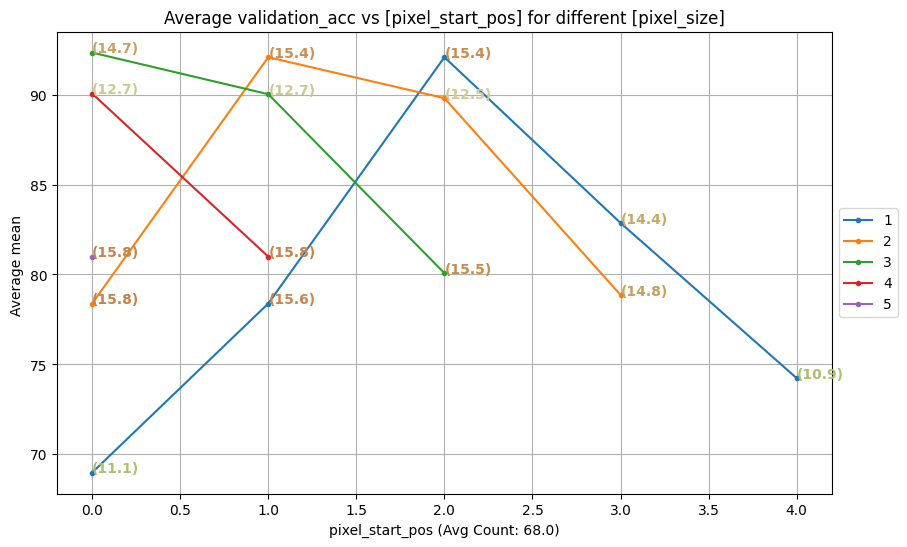

16.0


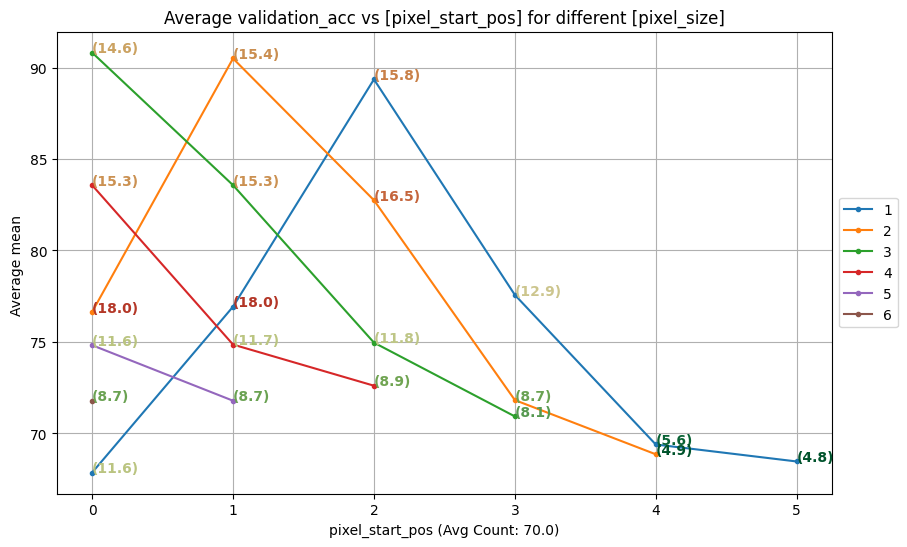

18.0


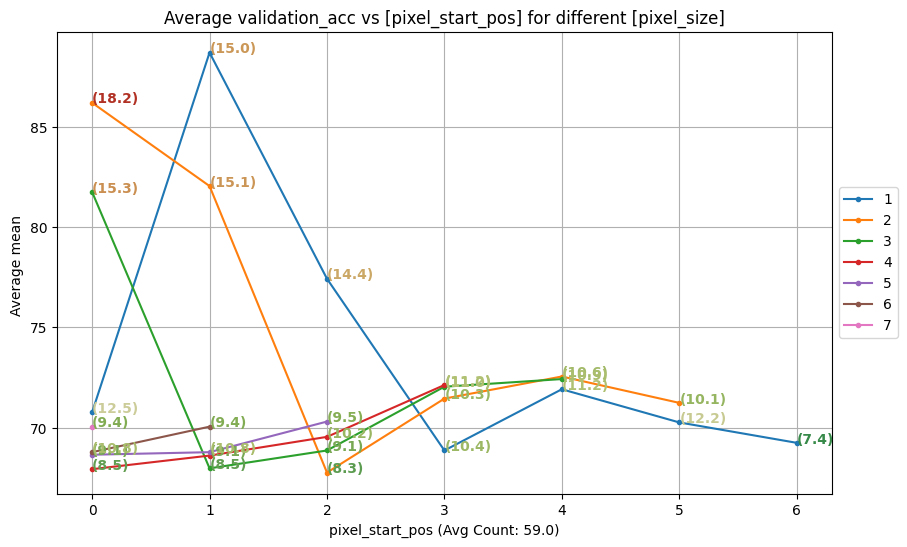

20.0


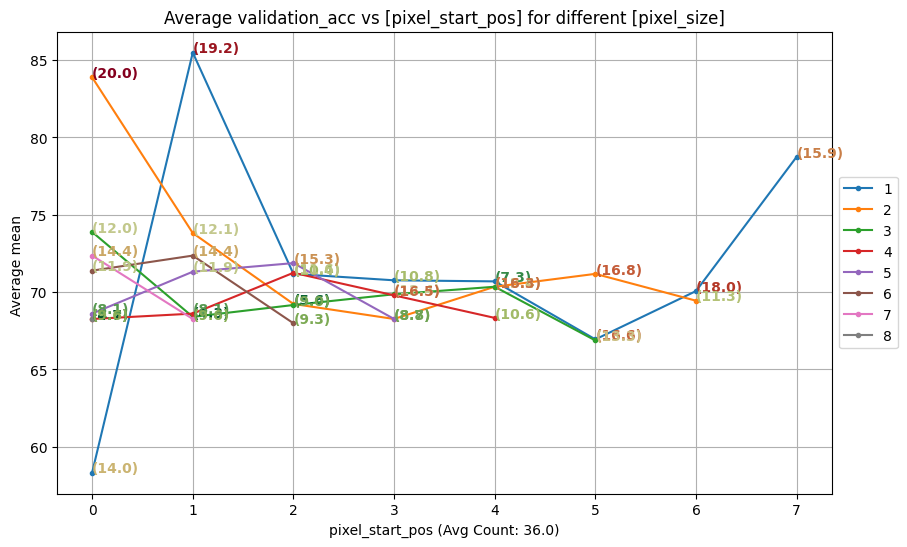

22.0


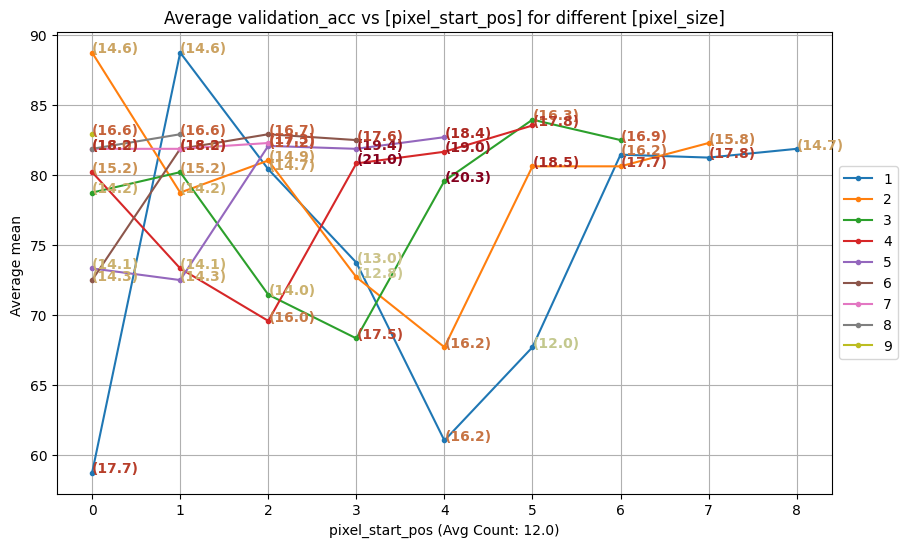

24.0
Condition 'diff_regressor' not found in column 'used_regressor'. Skipping this condition.
Condition 'max_value_regressor' not found in column 'used_regressor'. Skipping this condition.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


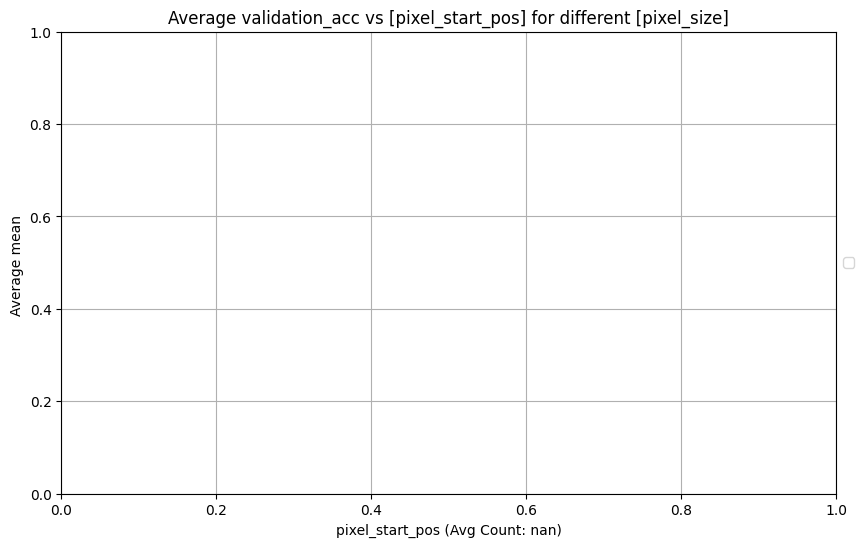

In [20]:
filt_out = {'used_regressor': ['diff_regressor','max_value_regressor']}#,'epoch': [0, 24]}#{'used_regressor': 'diff_regressor'}


#all_plots(case25_0_,figsize=(5,2),points_notation='std',filter_out=filt_out)
for x in np.linspace(14,24,6):
    print(x)
    plot_avg_accuracy(case31_0_pixel[case31_0_pixel['total_time']==int(x)], 'pixel_start_pos', 'pixel_size',filter_out=filt_out,points_notation='std',score_column='validation_acc')